In [ ]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from skimage.metrics import peak_signal_noise_ratio as psnr
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from torchvision.utils import make_grid

In [ ]:
def get_device_config():
  if(torch.cuda.is_available()):
    device = torch.device('cuda')
  else:
    device = torch.device('cpu')
  return device

# __Data Loading and Visualization__

## __Loading Datasets__

In [ ]:
mnist_dataset_train = datasets.MNIST(root='./data/train', train=True, download=True, transform=transforms.ToTensor())
mnist_dataset_test = datasets.MNIST(root='./data/test', train=False, download=True, transform=transforms.ToTensor())

os.makedirs('./data/Q1_train', exist_ok=True)
os.makedirs('./data/Q1_test', exist_ok=True)

for i, (img,label) in enumerate(mnist_dataset_train):
  save_image(img, f'./data/Q1_train/image{i+1}.png')


for i, (img,label) in enumerate(mnist_dataset_test):
  save_image(img, f'./data/Q1_test/image{i+1}.png')


In [ ]:
train_dataloader = DataLoader(mnist_dataset_train, batch_size=60, shuffle=True)
test_dataloader = DataLoader(mnist_dataset_test, batch_size=10, shuffle=True)

#Checking Train Dataloader Batch characteristics
for batch_features, batch_labels in train_dataloader:
  print(f"Train Batch Features: {batch_features.shape}")
  print(f"Train Batch Labels: {batch_labels.shape}")
  mini, maxi = batch_features[0].min(), batch_features[0].max()
  print(f"{mini} --- {maxi}")
  break

print("="*50)

#Checking Test Dataloader Batch characteristics
for batch_features, batch_labels in test_dataloader:
  print(f"Test Batch Features: {batch_features.shape}")
  print(f"Test Batch Labels: {batch_labels.shape}")
  mini, maxi = batch_features[0].min(), batch_features[0].max()
  torch.max(batch_features[0])
  print(f"{mini} --- {maxi}")
  break

Train Batch Features: torch.Size([60, 1, 28, 28])
Train Batch Labels: torch.Size([60])
0.0 --- 1.0
Test Batch Features: torch.Size([10, 1, 28, 28])
Test Batch Labels: torch.Size([10])
0.0 --- 1.0


## __Visualizing Data__

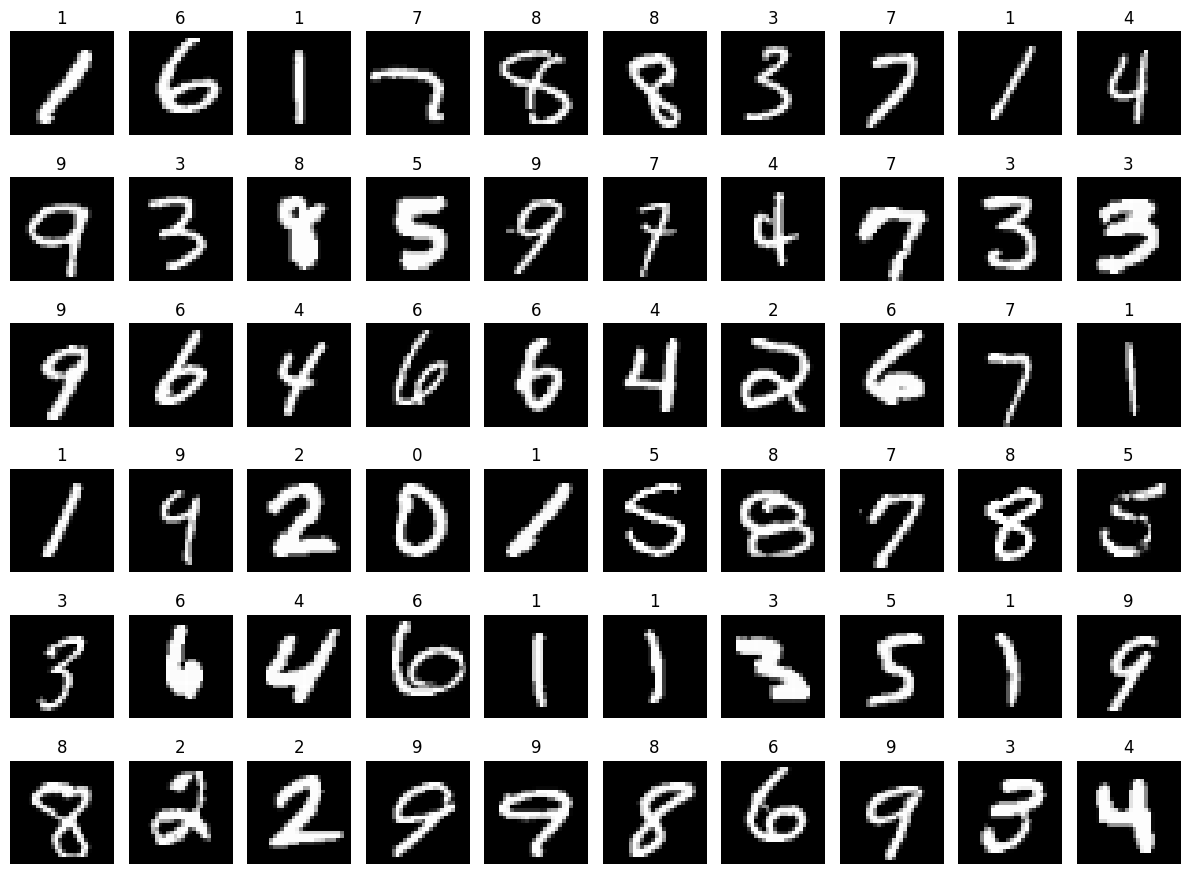

In [ ]:
fig, axes = plt.subplots(6, 10, figsize=(12,9))
axes = axes.flatten()

for i, (batch_features, batch_labels) in enumerate(train_dataloader):
  if(i == 60):
    break
  img = batch_features[i].squeeze()
  label = batch_labels[i]

  axes[i].imshow(img, cmap='gray')
  axes[i].set_title(label.item())
  axes[i].axis('off')

plt.tight_layout()
plt.show()




In [ ]:
def visualize_original_and_reconstructed_images(output):
  for i in range(0, 10):
    true_img_batch = output[i][1].detach().numpy()
    recon_img_batch = output[i][2].detach().numpy()
    img_loss = output[i][3]

    fig,axes = plt.subplots(2, 9, figsize=(14,5))
    axes = axes.flatten()
    fig.suptitle(f"Original vs Reconstructed Images Epoch {i + 1}(Loss: {img_loss:.4f})", fontsize=16)
    for j, item in enumerate(true_img_batch):
      if(j >= 9):
        break
      ax = axes[j]
      ax.imshow(item[0], cmap='gray')
      ax.axis('off')

    for j, item in enumerate(recon_img_batch):
      if(j >= 9):
        break
      ax = axes[j + 9]

      ax.imshow(item[0], cmap='gray')
      ax.axis('off')
    plt.tight_layout()
    plt.show()

# __1. Implementing Sparse and Contractive Autoencoders__

## __Impementing Sparse Autoencoder__

In [ ]:
class SparseAutoencoder(nn.Module):
  def __init__(self, rho = 0.01, lamb = 0.001):
    super().__init__()
    self.rho = rho
    self.lamb = lamb
    #Input Dimensions of an image: (1, 28, 28)
    self.encoder = nn.Sequential(
        nn.Conv2d(1, 16, 3, stride=1, padding=1), # Output Dimensions: (16, 28, 28)
        nn.ReLU(),
        nn.Conv2d(16, 32, 3, stride=1, padding=1), # Output Dimensions: (32, 28, 28)
        nn.ReLU(),
        nn.Conv2d(32, 64, 3, stride=1, padding=1), # Output Dimensions: (64, 28, 28)
        nn.ReLU()
    )

    #Input Dimensions of an image: (64, 28, 28)
    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(64, 32, 3, stride = 1, padding=1), # Output Dimensions: (32, 28, 28)
        nn.ReLU(),
        nn.ConvTranspose2d(32, 16, 3, stride=1, padding=1), # Output Dimensions: (16, 28, 28)
        nn.ReLU(),
        nn.ConvTranspose2d(16, 1, 3, stride=1, padding=1), # Output Dimensions: (1, 28, 28)
        nn.Sigmoid() # As we can see the max and min of the batch features is between 0 and 1 hence we choose Sigmoid Activation function
    )


  def forward(self, x):
    self.embeddings = self.encoder(x)
    decoded = self.decoder(self.embeddings)
    return decoded

  def calc_sparsity_loss(self):
    rho_hat = torch.mean(self.embeddings)
    rho_hat = torch.clamp(rho_hat, min=0.000001, max=0.999999)

    kl_sparsity_loss = self.rho * torch.log(self.rho/rho_hat) + (1-self.rho) * torch.log((1-self.rho)/(1-rho_hat))
    return self.lamb * torch.sum(kl_sparsity_loss)


In [ ]:
def train_sparse_autoencoder(epochs):
  if(torch.cuda.is_available()):
    device = torch.device('cuda')
  else:
    device = torch.device('cpu')

  model = SparseAutoencoder().to(device)
  optimizer = optim.Adam(model.parameters(), lr=0.005)
  loss_func = nn.BCELoss()
  output = []
  train_loss = []
  test_loss = []
  for e in range(epochs):
    epoch_train_loss = 0
    epoch_test_loss = 0
    for batch_features, batch_labels in train_dataloader:
      batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
      pred = model(batch_features)
      loss = loss_func(pred, batch_features)
      kl_sparse_loss = model.calc_sparsity_loss()
      loss = loss + kl_sparse_loss
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      epoch_train_loss = epoch_train_loss + loss.item()
    output.append((e, batch_features.to("cpu"), pred.to("cpu"), epoch_train_loss / len(train_dataloader)))
    train_loss.append(epoch_train_loss / len(train_dataloader))

    # Capturing test losses
    with torch.no_grad():
      for batch_features, batch_labels in test_dataloader:
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
        pred = model(batch_features)
        loss = loss_func(pred, batch_features)
        kl_sparse_loss = model.calc_sparsity_loss()
        loss = loss + kl_sparse_loss
        epoch_test_loss = epoch_test_loss + loss.item()
      test_loss.append(epoch_test_loss / (len(test_dataloader)))

    print(f"Epoch {e + 1} Avg. Train Loss: {epoch_train_loss / len(train_dataloader):.4f} ||| Avg. Test Loss: {epoch_test_loss / len(test_dataloader):.4f}")
    print("="*65)
  return output,train_loss, test_loss, model


In [ ]:
output_sparse_autoencoder, train_loss_sparse, test_loss_sparse, trained_sparse_autoencoder_model = train_sparse_autoencoder(10)

Epoch 1 Avg. Train Loss: 0.0642 ||| Avg. Test Loss: 0.0589
Epoch 2 Avg. Train Loss: 0.0589 ||| Avg. Test Loss: 0.0586
Epoch 3 Avg. Train Loss: 0.0587 ||| Avg. Test Loss: 0.0583
Epoch 4 Avg. Train Loss: 0.0586 ||| Avg. Test Loss: 0.0583
Epoch 5 Avg. Train Loss: 0.0586 ||| Avg. Test Loss: 0.0583
Epoch 6 Avg. Train Loss: 0.0598 ||| Avg. Test Loss: 0.0589
Epoch 7 Avg. Train Loss: 0.0588 ||| Avg. Test Loss: 0.0583
Epoch 8 Avg. Train Loss: 0.0586 ||| Avg. Test Loss: 0.0583
Epoch 9 Avg. Train Loss: 0.0585 ||| Avg. Test Loss: 0.0582
Epoch 10 Avg. Train Loss: 0.0585 ||| Avg. Test Loss: 0.0582


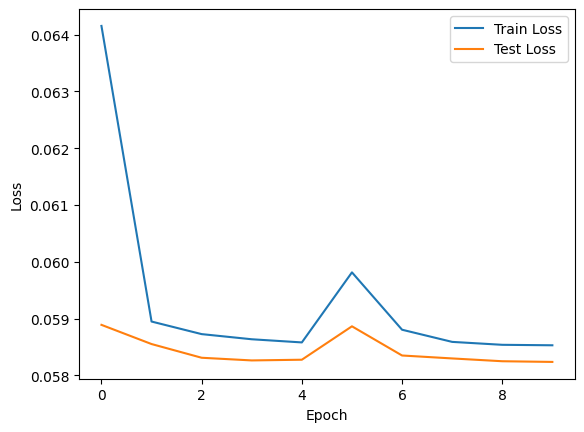

In [ ]:
plt.plot(train_loss_sparse, label='Train Loss')
plt.plot(test_loss_sparse, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

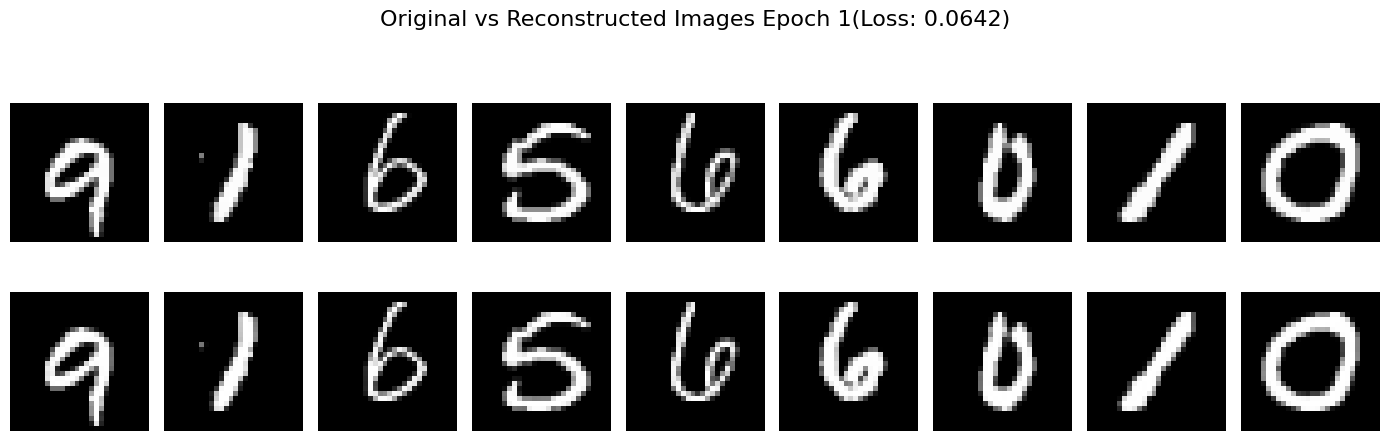

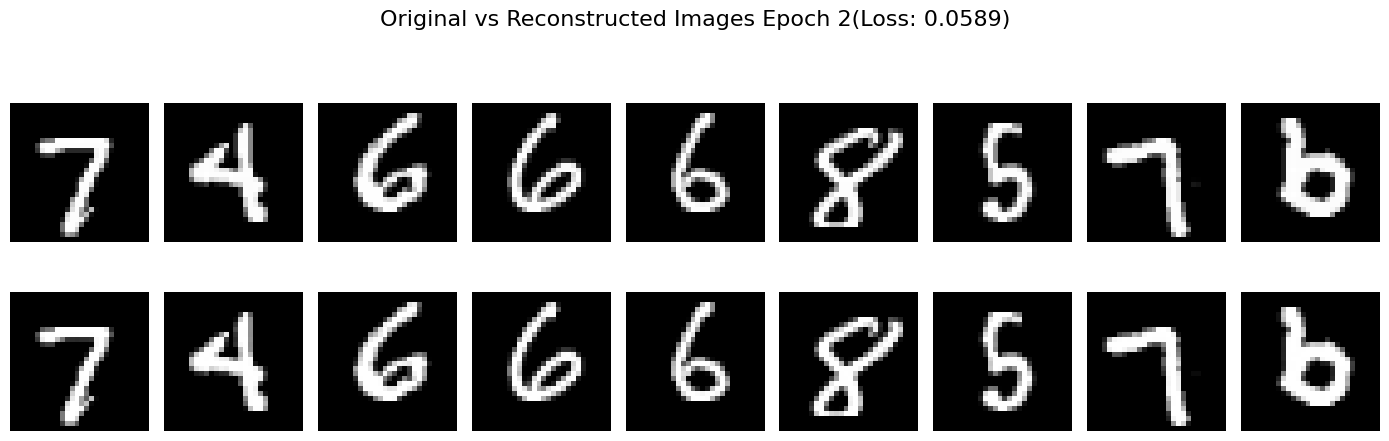

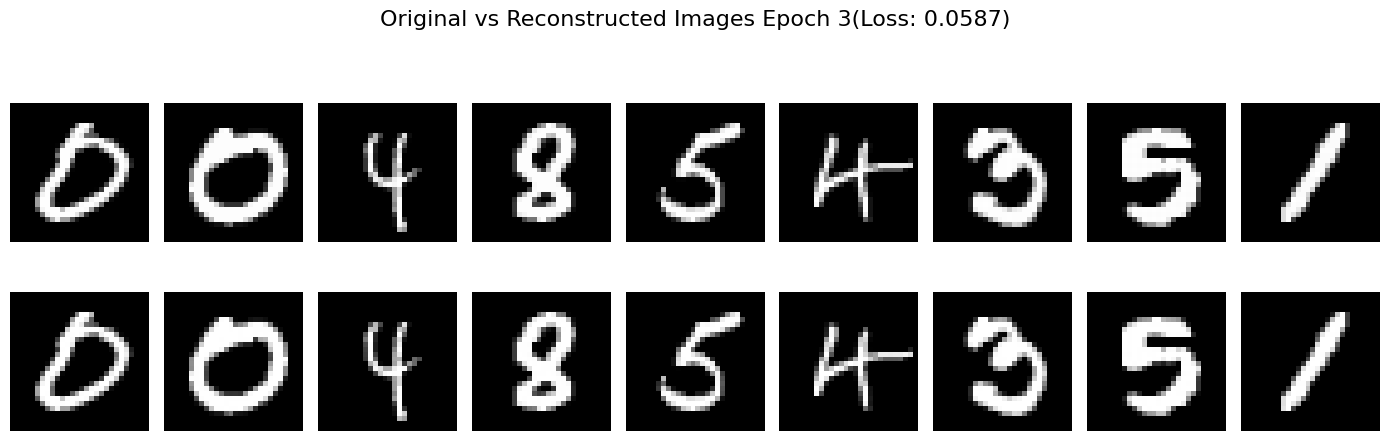

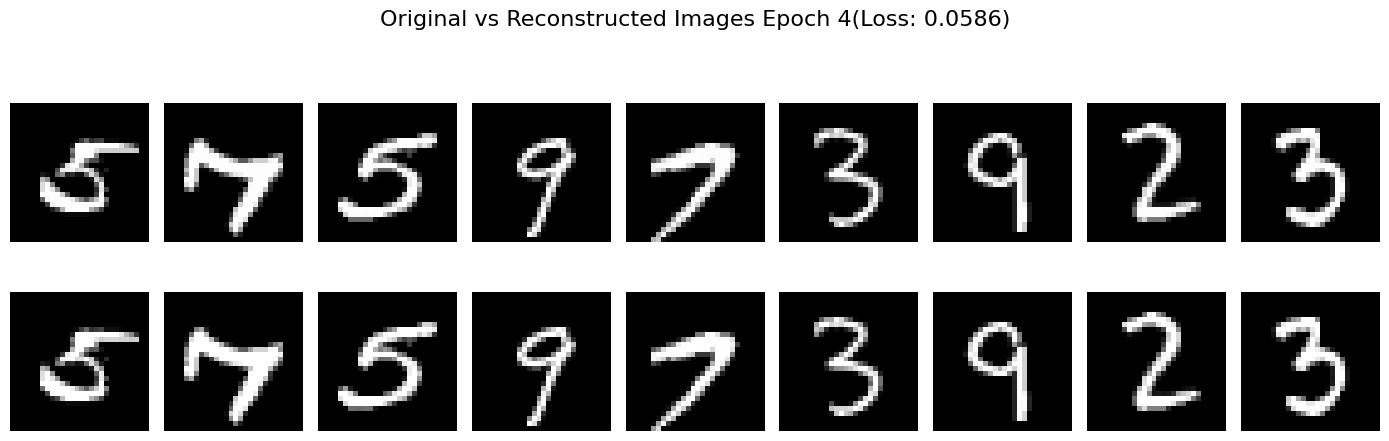

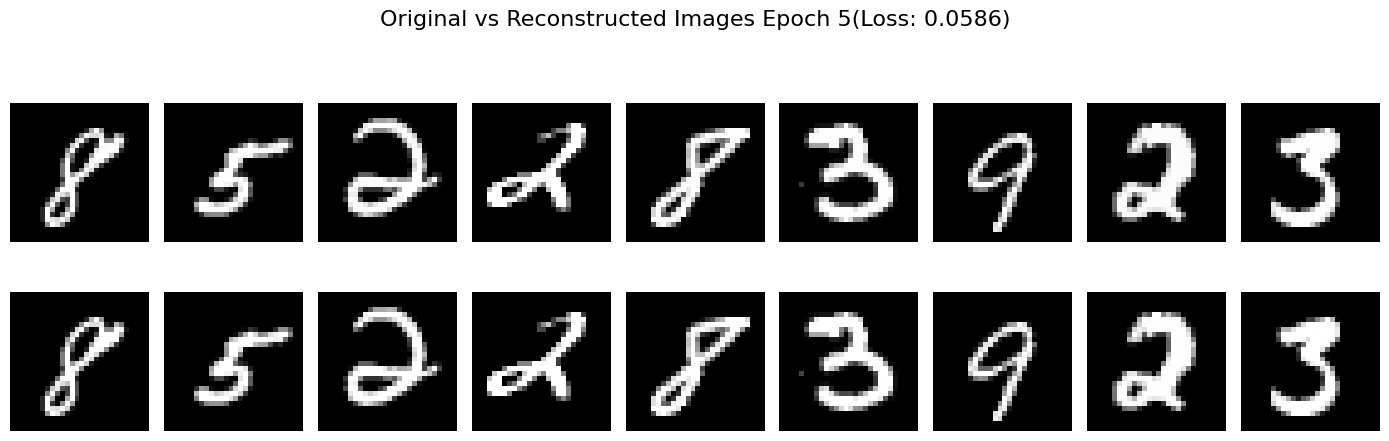

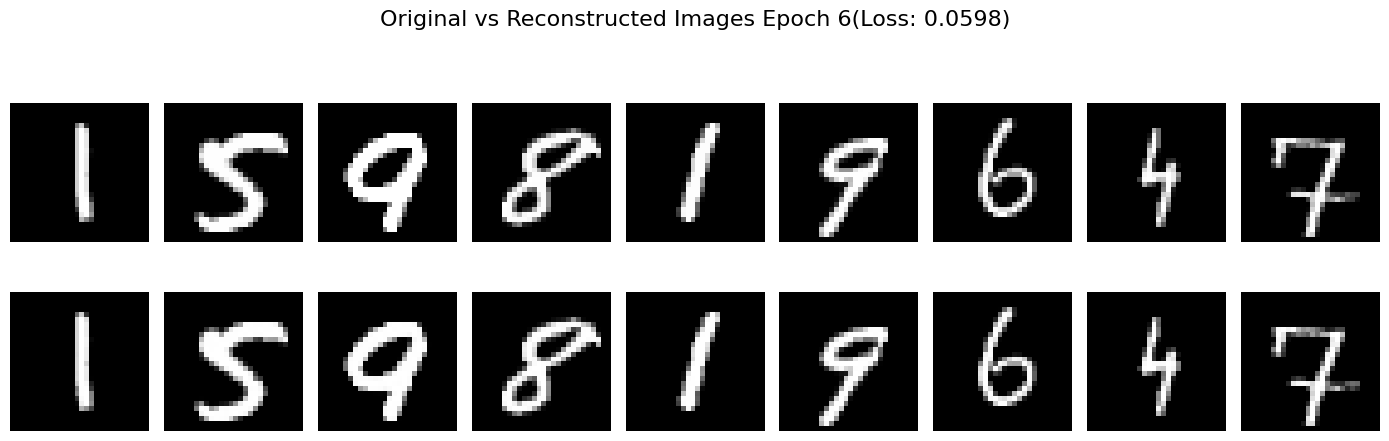

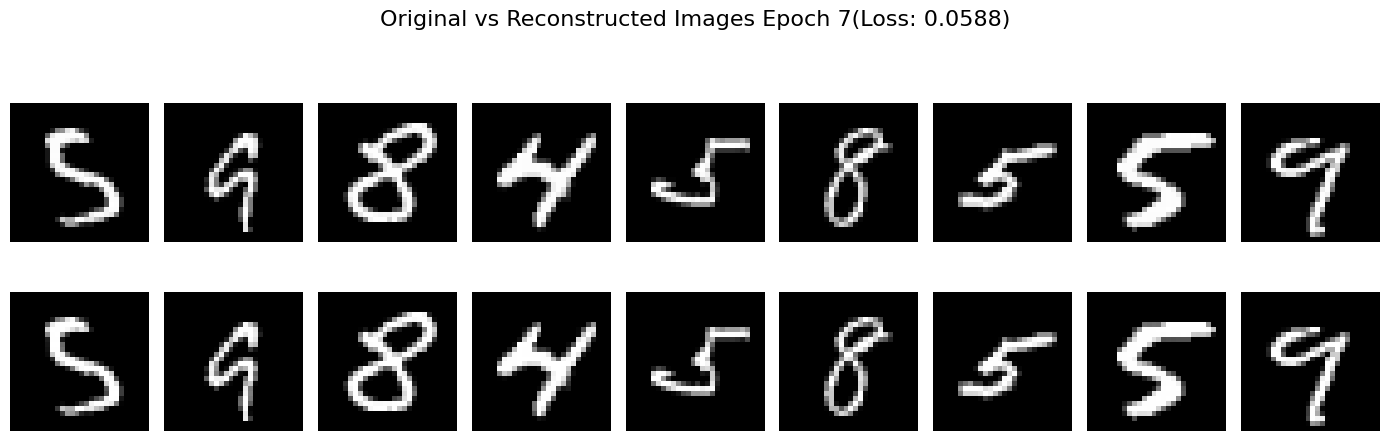

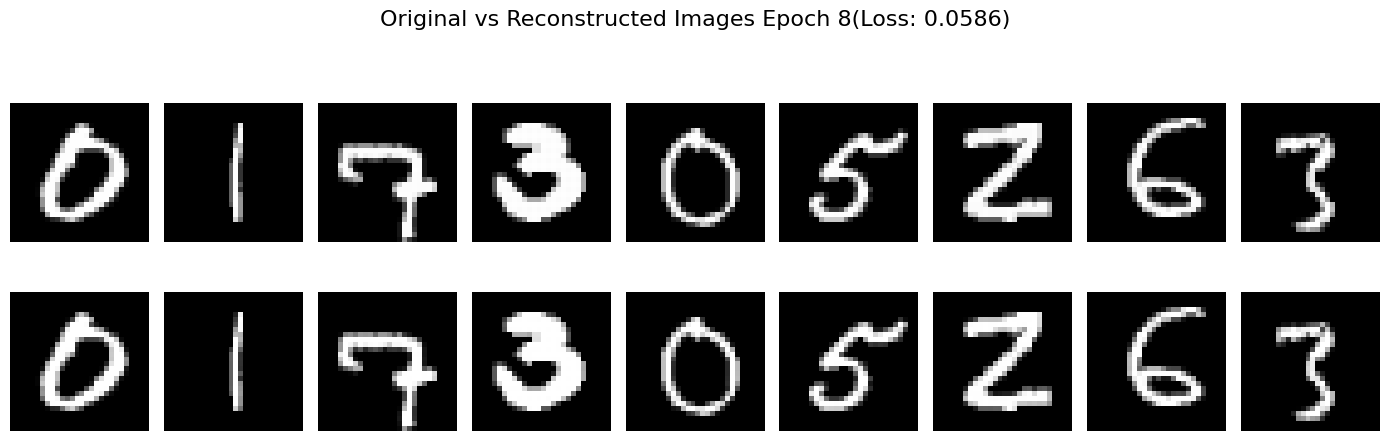

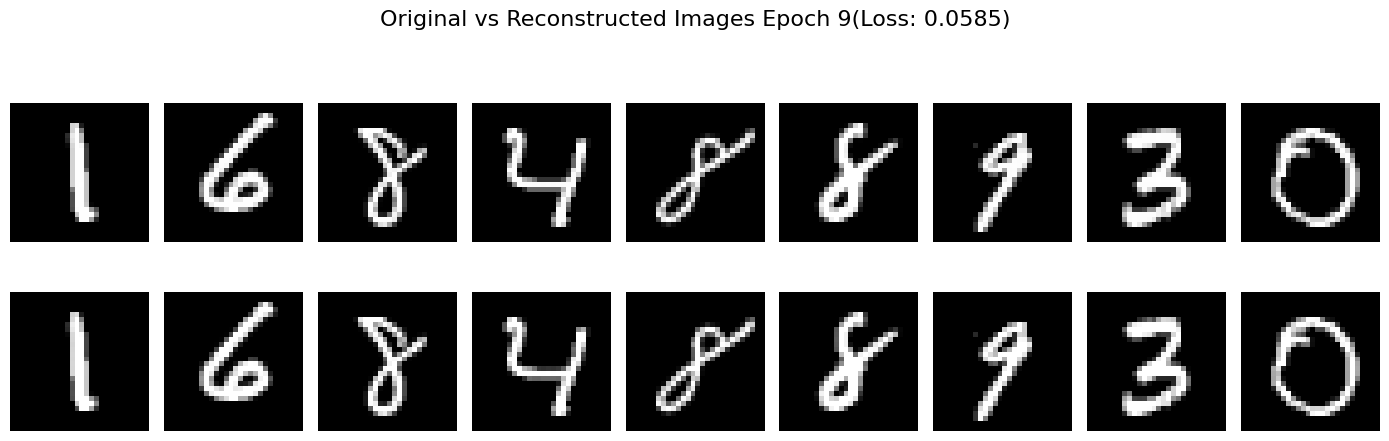

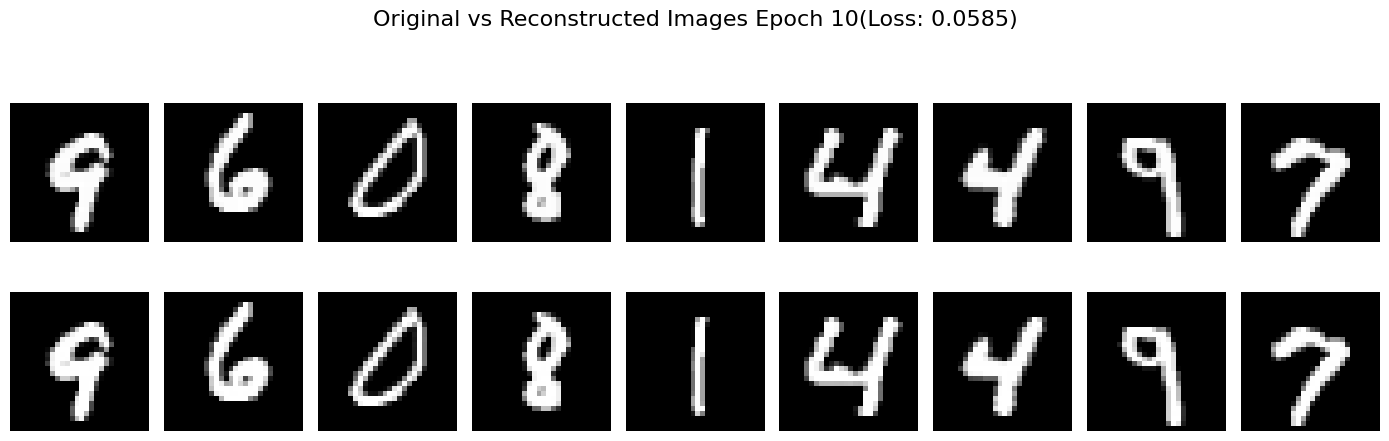

In [ ]:
visualize_original_and_reconstructed_images(output_sparse_autoencoder)

## __Implementing Contractive Autoencoder__

In [ ]:
class ContractiveAutoencoder(nn.Module):
  def __init__(self, rho = 0.01, lamb = 1e-5):
    super().__init__()
    self.rho = rho
    self.lamb = lamb
    #Input Dimensions of an image: (1, 28, 28)
    self.encoder = nn.Sequential(
        nn.Conv2d(1, 16, 3, stride=1, padding=1), # Output Dimensions: (16, 28, 28)
        nn.ReLU(),
        nn.Conv2d(16, 32, 3, stride=1, padding=1), # Output Dimensions: (32, 28, 28)
        nn.ReLU(),
        nn.Conv2d(32, 64, 3, stride=1, padding=1), # Output Dimensions: (64, 28, 28)
        nn.ReLU()
    )

    #Input Dimensions of an image: (64, 28, 28)
    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(64, 32, 3, stride = 1, padding=1), # Output Dimensions: (32, 28, 28)
        nn.ReLU(),
        nn.ConvTranspose2d(32, 16, 3, stride=1, padding=1), # Output Dimensions: (16, 28, 28)
        nn.ReLU(),
        nn.ConvTranspose2d(16, 1, 3, stride=1, padding=1), # Output Dimensions: (1, 28, 28)
        nn.Sigmoid() # As we can see the max and min of the batch features is between 0 and 1 hence we choose Sigmoid Activation function
    )


  def forward(self, x):
    x = x.to(next(self.parameters()).device)
    x = x.clone().detach().requires_grad_(True)
    self.input= x
    self.embeddings = self.encoder(self.input)
    decoded = self.decoder(self.embeddings)
    return decoded

  def calc_contractive_loss(self):
    sum_of_activation_vals = torch.sum(self.embeddings)

    # Compute gradients of encoder output sum w.r.t input
    grads = torch.autograd.grad(outputs=sum_of_activation_vals, inputs=self.input,
                                create_graph=True, retain_graph=True)[0]

    # Frobenius norm of the Jacobian approximation
    contractive_loss = torch.sum(grads ** 2)
    return self.lamb * contractive_loss

In [ ]:
def train_contractive_autoencoder(epochs):
  device = get_device_config()

  model = ContractiveAutoencoder().to(device)
  optimizer = optim.Adam(model.parameters(), lr=0.001)
  loss_func = nn.BCELoss()
  output = []
  train_loss = []
  test_loss = []
  for e in range(epochs):
    epoch_train_loss = 0
    epoch_test_loss = 0
    for batch_features, batch_labels in train_dataloader:
      batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
      pred = model(batch_features)
      loss = loss_func(pred, batch_features)
      contractive_loss = model.calc_contractive_loss()
      loss = loss + contractive_loss
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      epoch_train_loss = epoch_train_loss + loss.item()
    output.append((e, batch_features.to("cpu"), pred.to("cpu"), epoch_train_loss / len(train_dataloader)))
    train_loss.append(epoch_train_loss / len(train_dataloader))

    # Capturing test losses
    with torch.no_grad():
      for batch_features, batch_labels in test_dataloader:
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
        pred = model(batch_features)
        loss = loss_func(pred, batch_features)
        # contractive_loss = model.calc_contractive_loss()
        loss = loss
        epoch_test_loss = epoch_test_loss + loss.item()
      test_loss.append(epoch_test_loss / (len(test_dataloader)))

    print(f"Epoch {e + 1} Avg. Train Loss: {epoch_train_loss / len(train_dataloader):.4f} ||| Avg. Test Loss: {epoch_test_loss / len(test_dataloader):.4f}")
    print("="*65)
  return output,train_loss, test_loss, model

In [ ]:
output_contractive_autoencoder, train_loss_contractive, test_loss_contractive, trained_contractive_autoencoder_model = train_contractive_autoencoder(10)

Epoch 1 Avg. Train Loss: 0.2695 ||| Avg. Test Loss: 0.0627
Epoch 2 Avg. Train Loss: 0.0661 ||| Avg. Test Loss: 0.0614
Epoch 3 Avg. Train Loss: 0.0633 ||| Avg. Test Loss: 0.0605
Epoch 4 Avg. Train Loss: 0.3009 ||| Avg. Test Loss: 0.0637
Epoch 5 Avg. Train Loss: 0.0673 ||| Avg. Test Loss: 0.0624
Epoch 6 Avg. Train Loss: 0.0641 ||| Avg. Test Loss: 0.0616
Epoch 7 Avg. Train Loss: 0.0630 ||| Avg. Test Loss: 0.0610
Epoch 8 Avg. Train Loss: 0.0626 ||| Avg. Test Loss: 0.0605
Epoch 9 Avg. Train Loss: 0.0629 ||| Avg. Test Loss: 0.0606
Epoch 10 Avg. Train Loss: 0.0615 ||| Avg. Test Loss: 0.0705


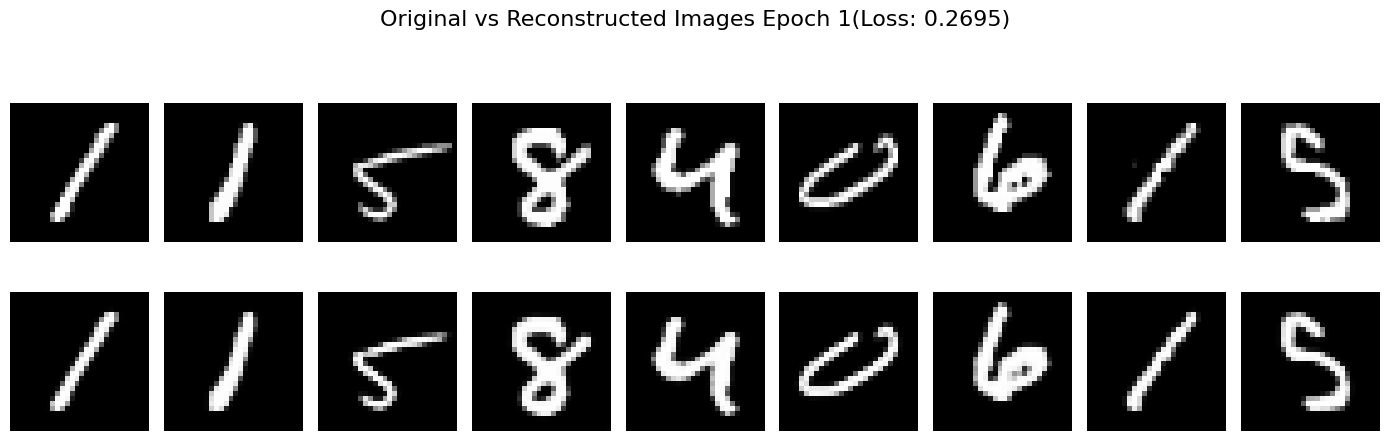

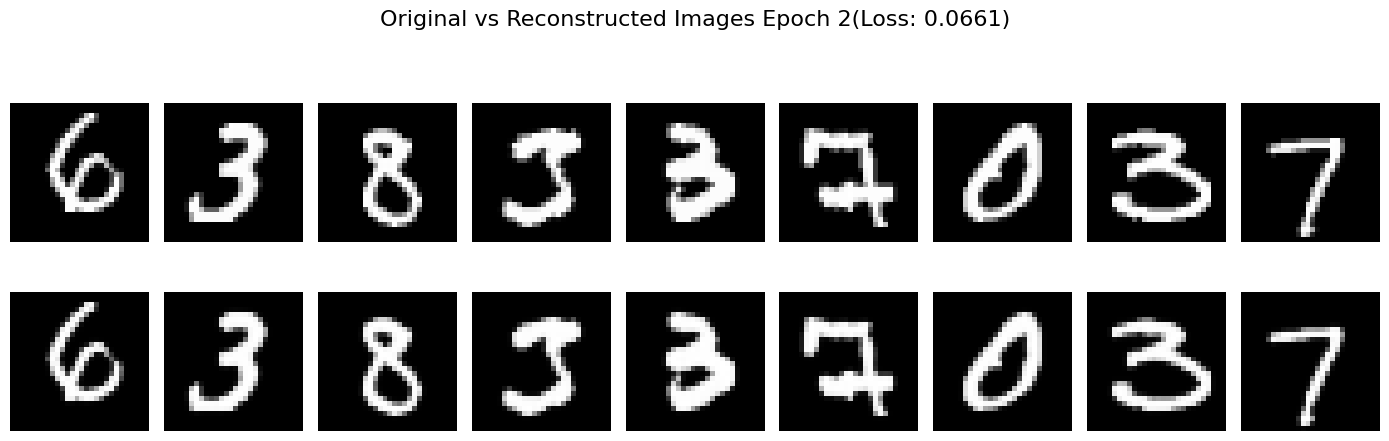

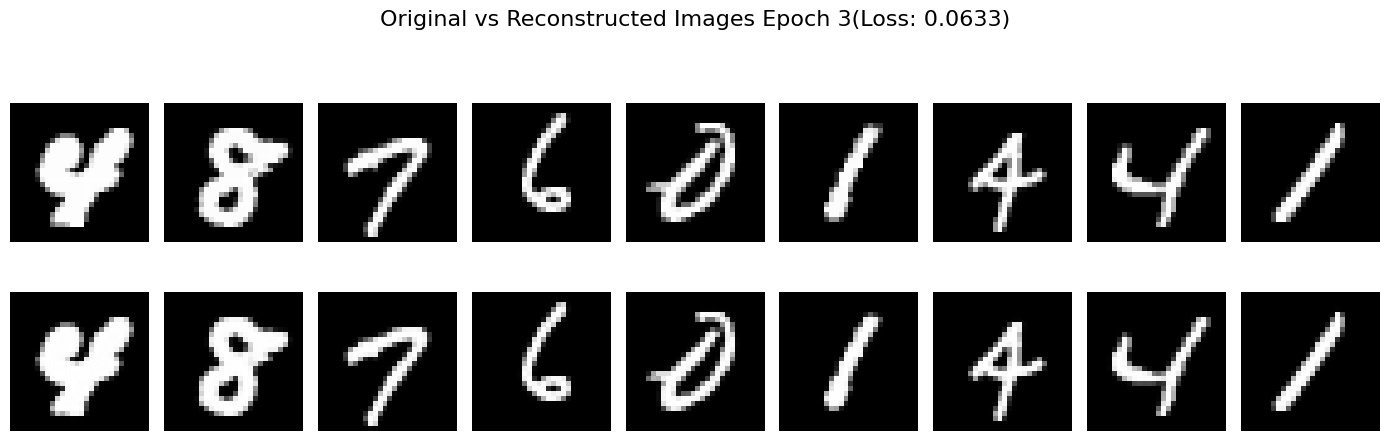

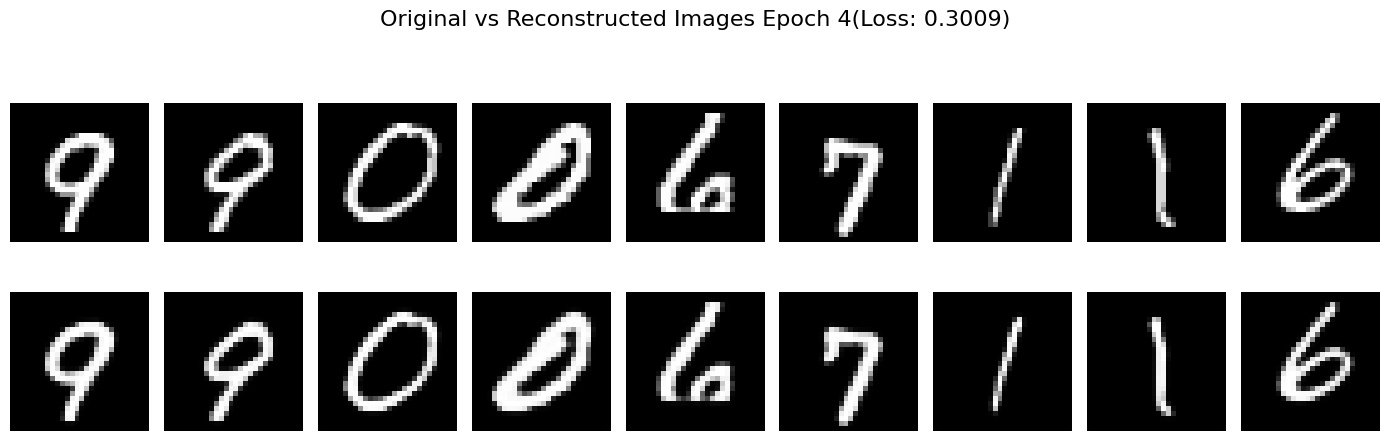

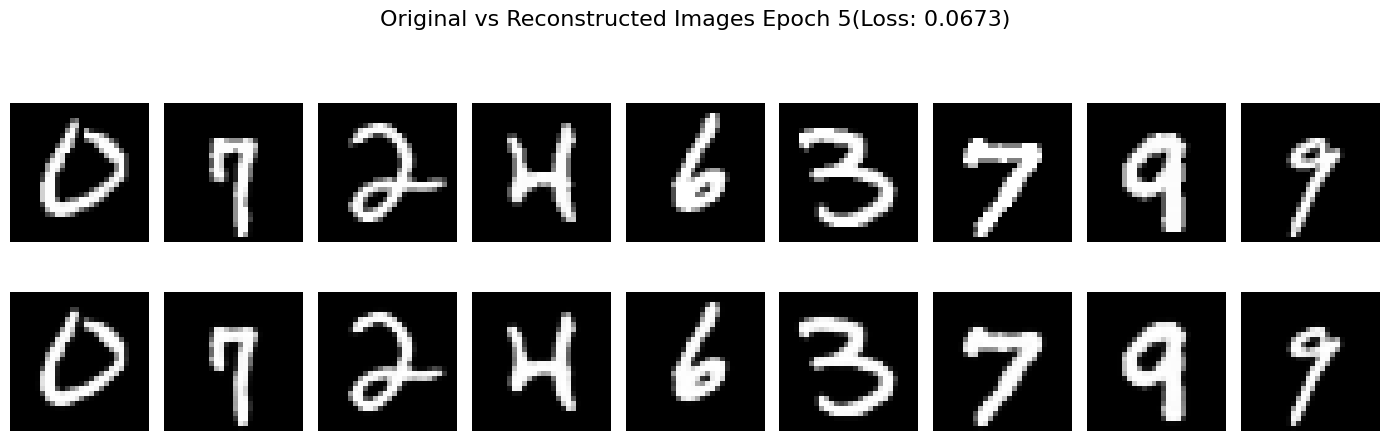

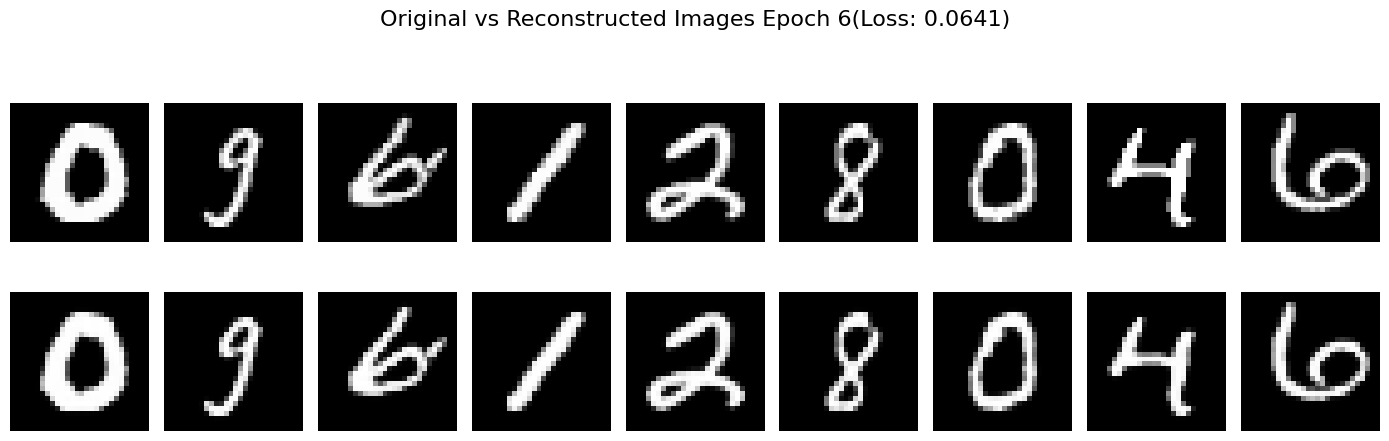

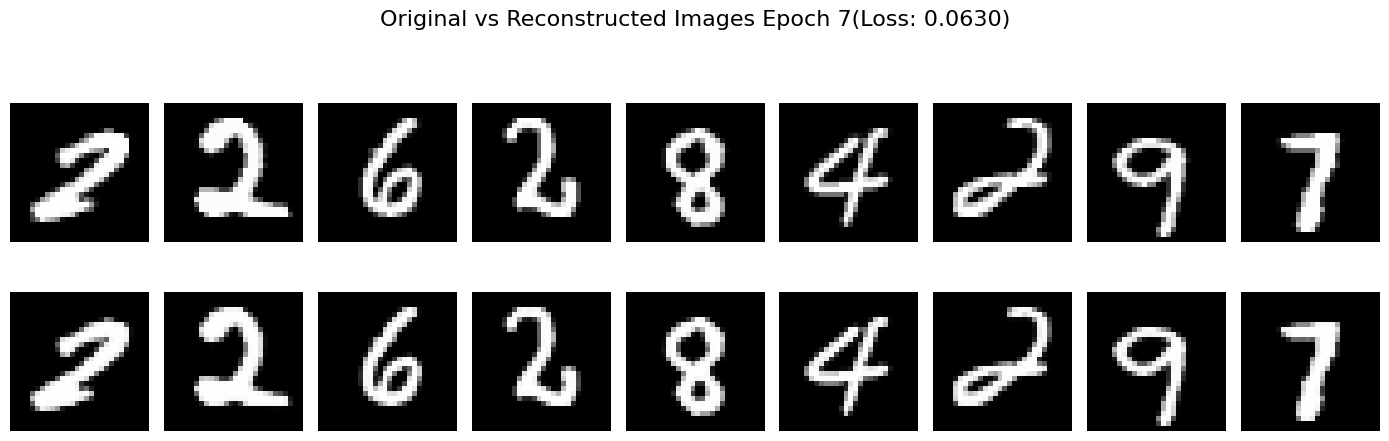

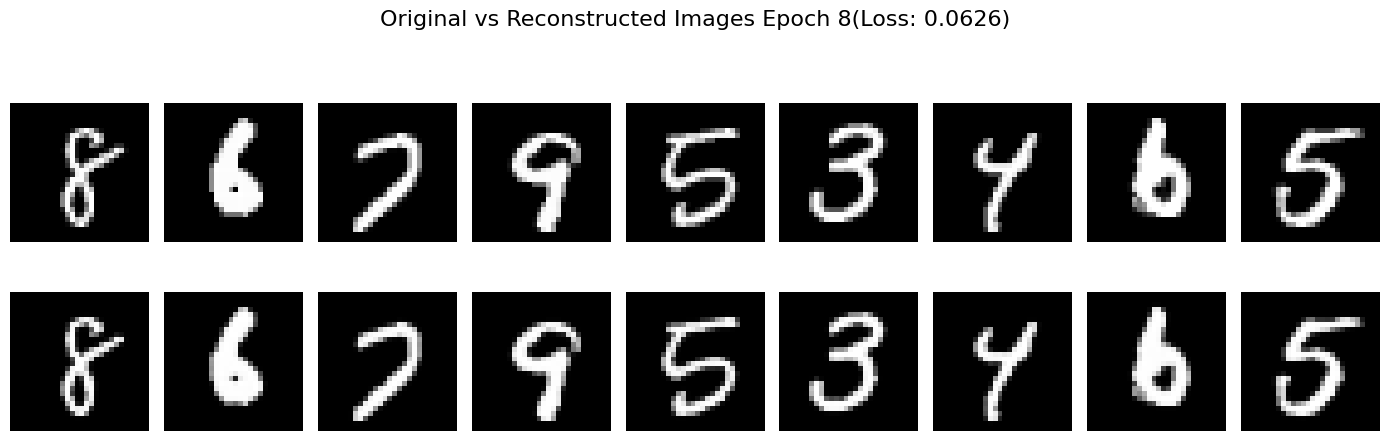

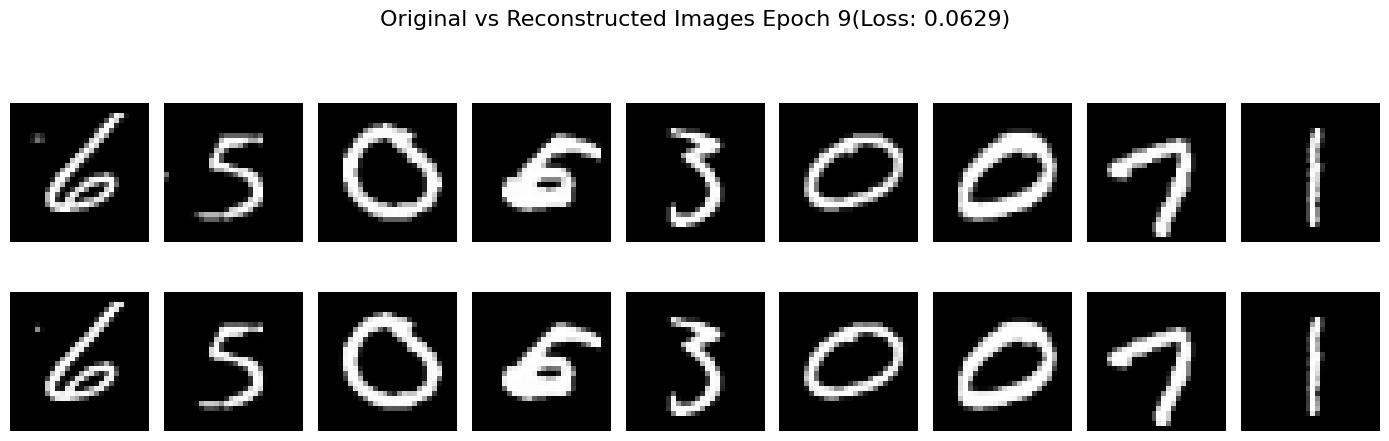

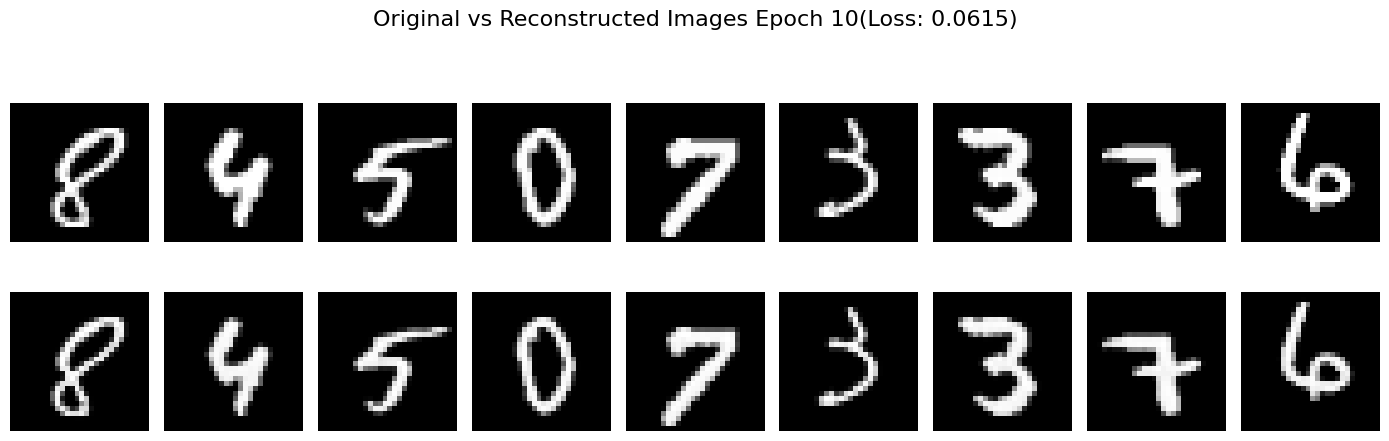

In [ ]:
visualize_original_and_reconstructed_images(output_contractive_autoencoder)

## __Visualize Feature Maps__

Visualization for Sparse Autoencoder


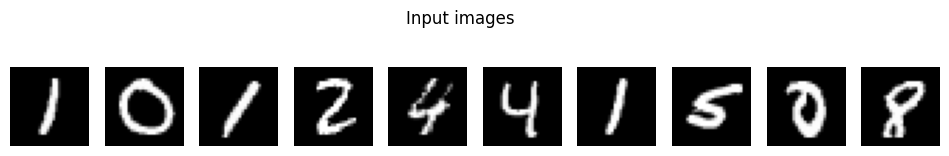

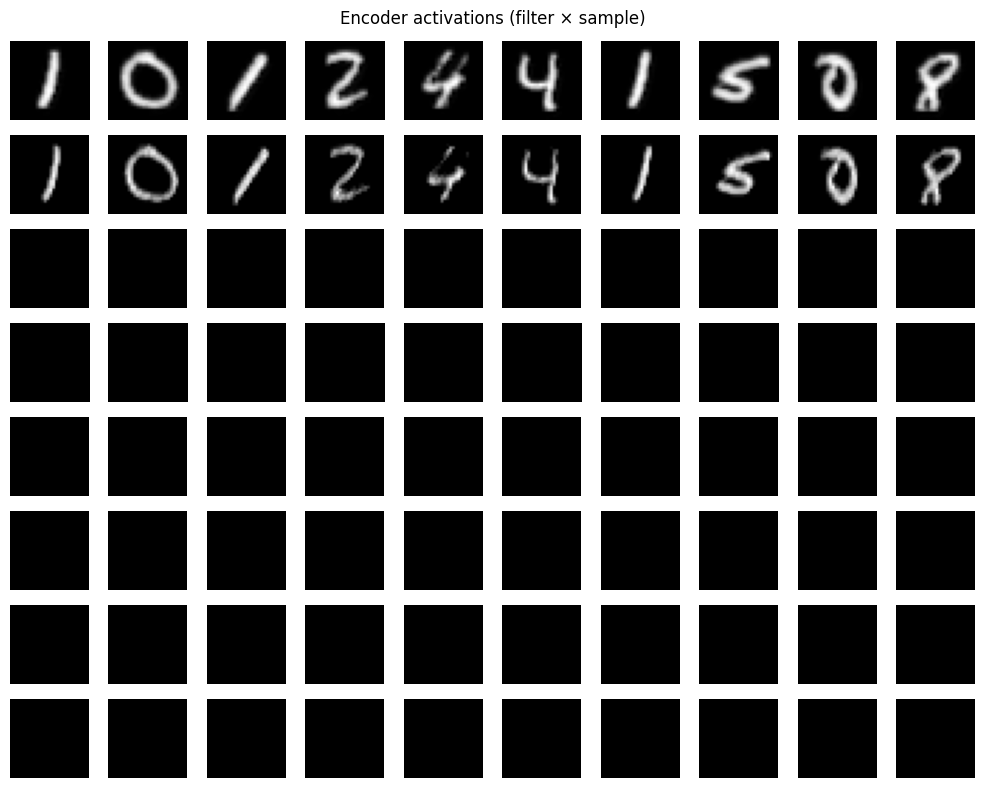

Visualization for Contractive Autoencoder


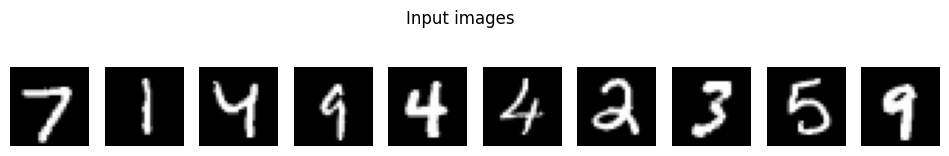

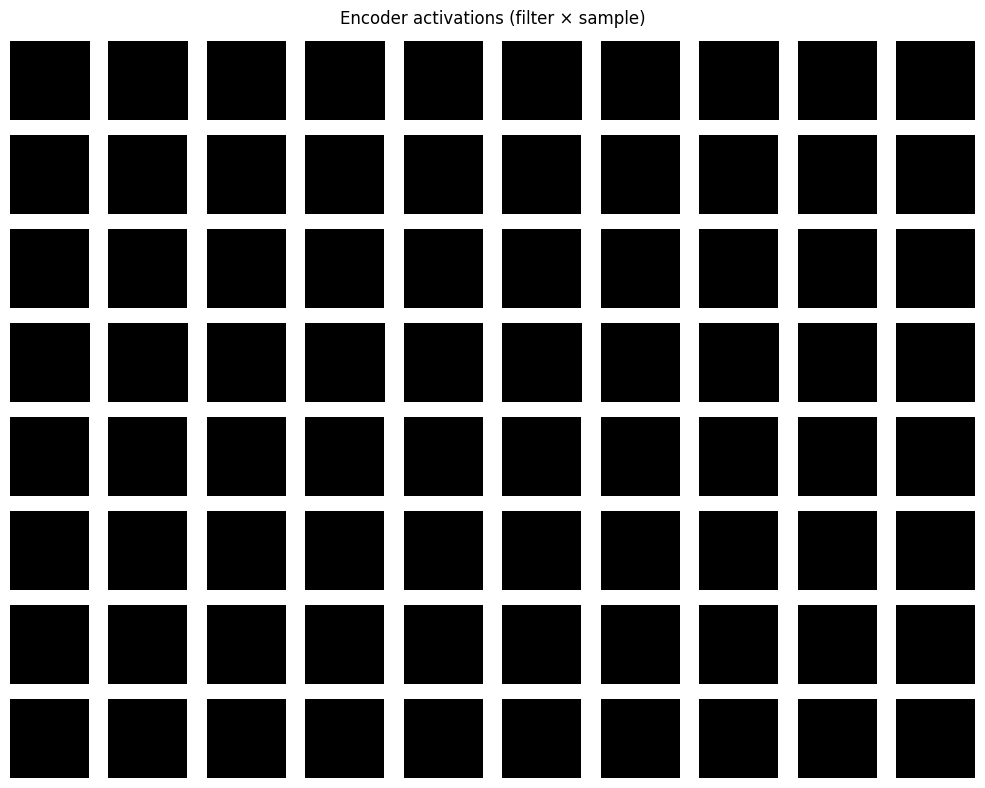

In [ ]:
def visualize_featuremaps(model, encoder_type):
  print(f"Visualization for {encoder_type}")
  device = get_device_config()
  model.eval()
  with torch.no_grad():
      imgs, _    = next(iter(test_dataloader))
      imgs_small = imgs[:10]
      model.to(device)
      embs = model.encoder(imgs_small.to(device))
      embs = embs.cpu().numpy()

  imgs_np = imgs_small.numpy().squeeze(axis=1)

  n_samples = imgs_np.shape[0]
  n_filters = int(embs.shape[1] / 8)

  fig, axes = plt.subplots(1, n_samples, figsize=(12, 2))
  for i in range(n_samples):
      axes[i].imshow(imgs_np[i], cmap='gray')
      axes[i].axis('off')
  fig.suptitle("Input images")
  plt.show()

  # Plotting each featuremap but restricting upto 8 feature maps( 64 / 8)
  fig, axes = plt.subplots(n_filters, n_samples, figsize=(n_samples, n_filters))
  for f in range(n_filters):
      for i in range(n_samples):
          axes[f, i].imshow(embs[i, f], cmap='gray')
          axes[f, i].axis('off')
  fig.suptitle("Encoder activations (filter × sample)")
  plt.tight_layout()
  plt.show()




visualize_featuremaps(trained_sparse_autoencoder_model, "Sparse Autoencoder")
visualize_featuremaps(trained_contractive_autoencoder_model, "Contractive Autoencoder")

## __(a) Plot the t-sne (use inbuilt function) on the embeddings obtained using the respective auto-encoders. Color the clusters using the respective ground-truth class labels.__

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
def plot_tsne(model, encoder_type, n_samples):
    model.eval()
    device = next(model.parameters()).device
    embeddings, labels = [], []
    with torch.no_grad():
        for batch_features, batch_labels in test_dataloader:
            batch_features = batch_features.to(device)
            h = model.encoder(batch_features)
            embeddings.append(h.cpu().numpy().reshape(h.shape[0], -1))
            labels.append(batch_labels.numpy())
            if len(embeddings)*batch_features.shape[0] >= n_samples:
                break

    embeddings = np.concatenate(embeddings)[:n_samples]
    labels = np.concatenate(labels)[:n_samples]
    tsne = TSNE(n_components=2, random_state=101)
    emb_2d = tsne.fit_transform(embeddings)
    plt.figure(figsize=(8,6))
    plt.scatter(emb_2d[:,0], emb_2d[:,1], c=labels, cmap='tab10', s=5)
    plt.colorbar()
    plt.title(f"t-SNE of {encoder_type} Embeddings")
    plt.show()


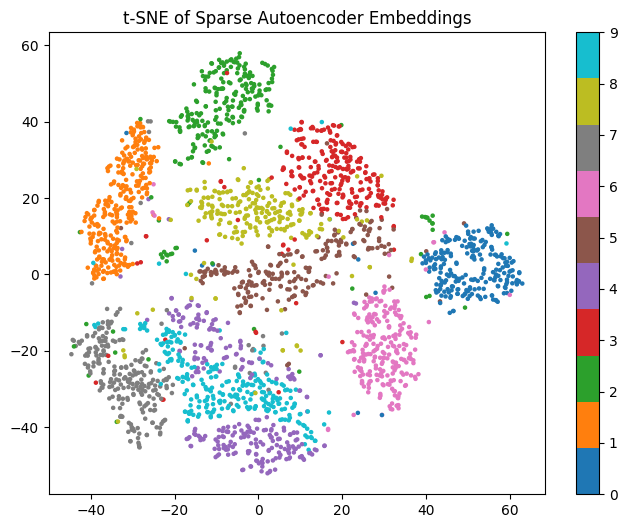

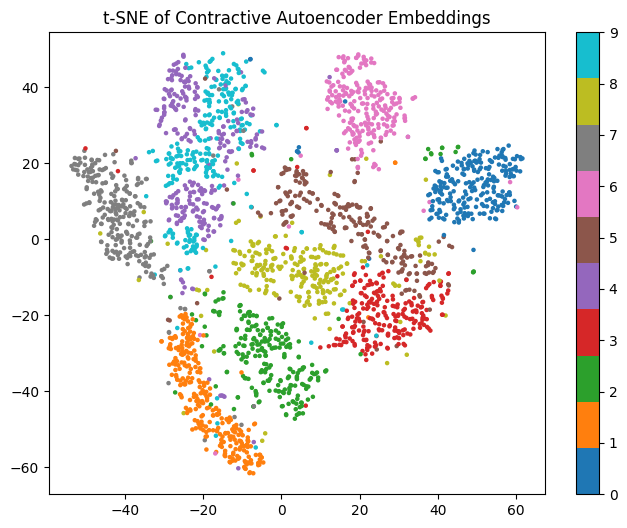

In [ ]:
plot_tsne(trained_sparse_autoencoder_model, "Sparse Autoencoder", 2500)
plot_tsne(trained_contractive_autoencoder_model, "Contractive Autoencoder", 2500)

## __(b) Randomly take two images I1 and I2 from two different digit classes. Let h1 = E(I1) and h2 = E(I2) be the embeddings for these images, respectively. Construct another image Iα = αI1+(1−α)I2 for α = 0, 0.2, 0.4, 0.6, 0.8, 1. Find the embedding hα of this image Iα for all values of α by passing it through the encoder. Also, consider the approximate embedding hα = αh1 + (1−α)h2 by using directly the embeddings of the images I1 and I2. Also, find ˆIα = D(hα) and ˆI′α = D(h′α). Plot the images ˆIα and ˆI′α side by side for different values of α. Do this for 20 pairs (I1, I2). Report PSNR between ˆIα and ˆI′α and find ∥hˆα − hˆ′α∥2 for all values of alpha.__

In [ ]:
def extract_and_compare(model, encoder_type, n_pairs=20):
    device = get_device_config()
    model.eval()
    model.to(device)
    alphas = [0, 0.2, 0.4, 0.6, 0.8, 1]
    psnrs, l2_embedding_norms = [], []
    for e in range(n_pairs):
        batch_features, batch_labels = next(iter(test_dataloader))
        indices = torch.randperm(len(batch_labels))[:2]
        picked_labels = batch_labels[indices]
        picked_features = batch_features[indices]
        img1, img2 = picked_features[0], picked_features[1]
        img1, img2 = img1.unsqueeze(0).to(device), img2.unsqueeze(0).to(device)
        h1, h2 = model.encoder(img1), model.encoder(img2)
        recon_img_original, recon_img_formula_embeddings = [], []
        for alpha in alphas:
            I_alpha = alpha*img1 + (1-alpha)*img2
            h_alpha = model.encoder(I_alpha)
            h_prime_alpha = alpha*h1 + (1-alpha)*h2
            I_hat_alpha = model.decoder(h_alpha) # Reconstructed image using the model encoder embeddings
            I_hat_prime_alpha = model.decoder(h_prime_alpha) # Reconstructed image using the formula and embeddings of img1 and img2
            recon_img_original.append(I_hat_alpha.squeeze().cpu().detach().numpy())
            recon_img_formula_embeddings.append(I_hat_prime_alpha.squeeze().cpu().detach().numpy())
            psnrs.append(psnr(I_hat_alpha.squeeze().cpu().detach().numpy(), I_hat_prime_alpha.squeeze().cpu().detach().numpy(), data_range=2))
            l2_embedding_norms.append(torch.norm(h_alpha - h_prime_alpha).item())

        fig, axs = plt.subplots(2, len(alphas), figsize=(12,4))
        print("="*10 + f" BEGINNING OF {encoder_type} Autoencoder RUN {e+1}" + "="*10)
        for i in range(len(alphas)):
            axs[0,i].imshow(recon_img_original[i], cmap='gray')
            axs[0,i].axis('off')
            axs[0,i].set_title(alphas[i])
            axs[1,i].imshow(recon_img_formula_embeddings[i], cmap='gray')
            axs[1,i].axis('off')
        plt.suptitle("Top: I_hat_alpha, Bottom: I_hat_prime_alpha")
        plt.show()
    print(f"Mean PSNR: {np.mean(psnrs):.2f}, Mean L2: {np.mean(l2_embedding_norms):.4f}\n")

========== BEGINNING OF Sparse Autoencoder Autoencoder RUN 1==========


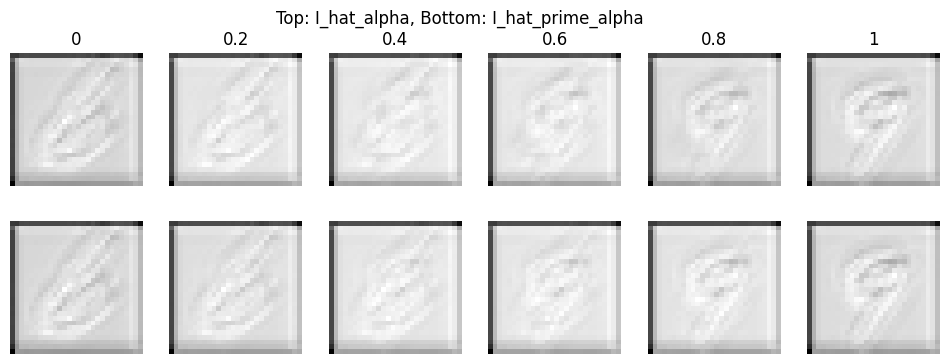

========== BEGINNING OF Sparse Autoencoder Autoencoder RUN 2==========


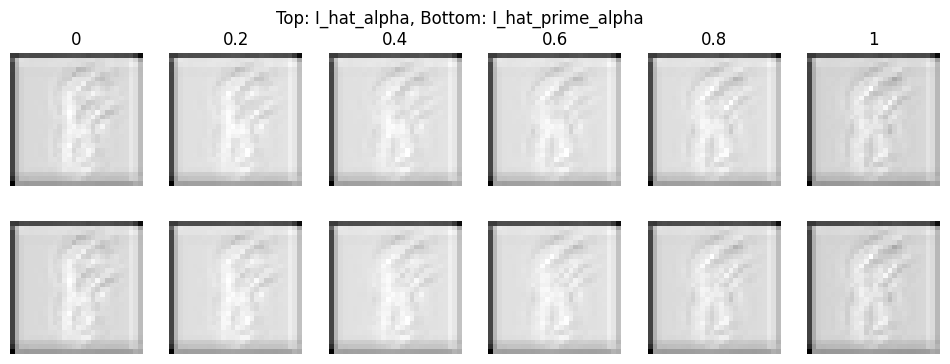

========== BEGINNING OF Sparse Autoencoder Autoencoder RUN 3==========


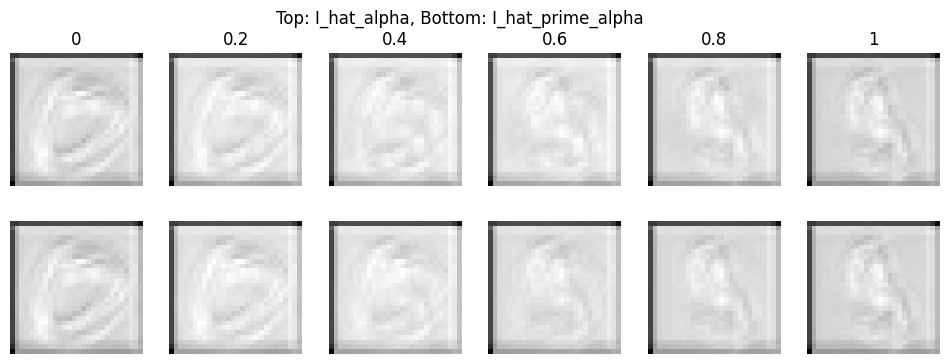

========== BEGINNING OF Sparse Autoencoder Autoencoder RUN 4==========


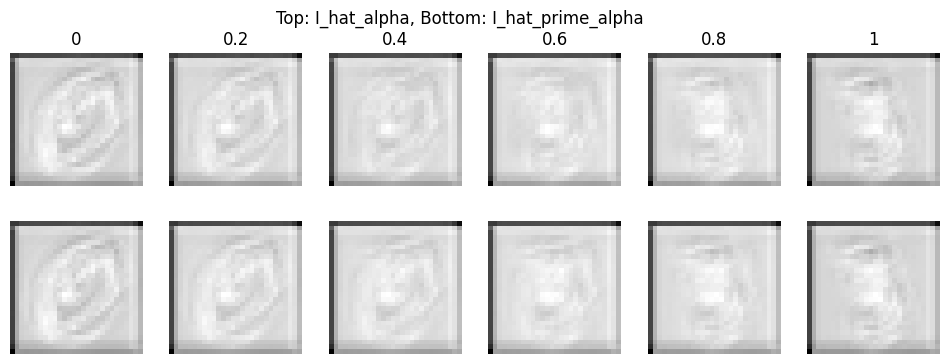

========== BEGINNING OF Sparse Autoencoder Autoencoder RUN 5==========


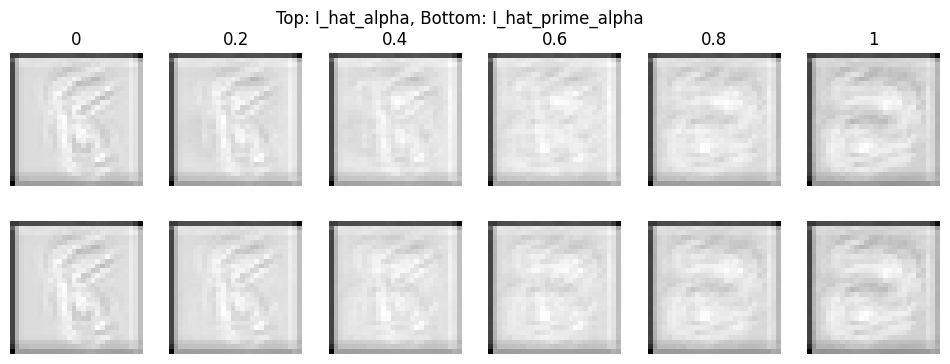

/usr/local/lib/python3.11/dist-packages/skimage/metrics/simple_metrics.py:168: RuntimeWarning: divide by zero encountered in scalar divide
  return 10 * np.log10((data_range**2) / err)


========== BEGINNING OF Sparse Autoencoder Autoencoder RUN 6==========


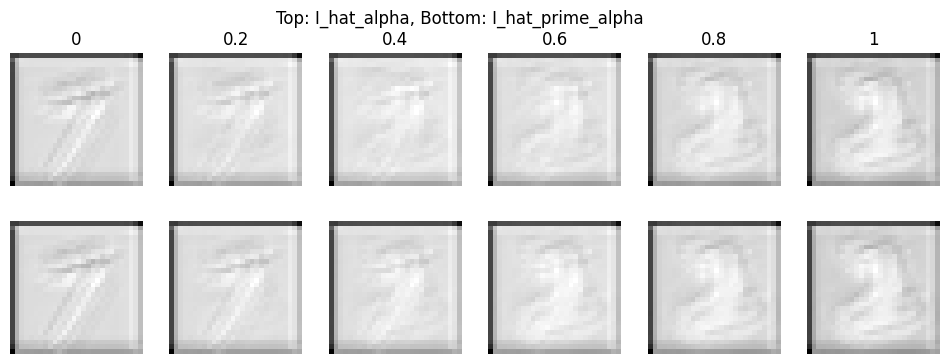

========== BEGINNING OF Sparse Autoencoder Autoencoder RUN 7==========


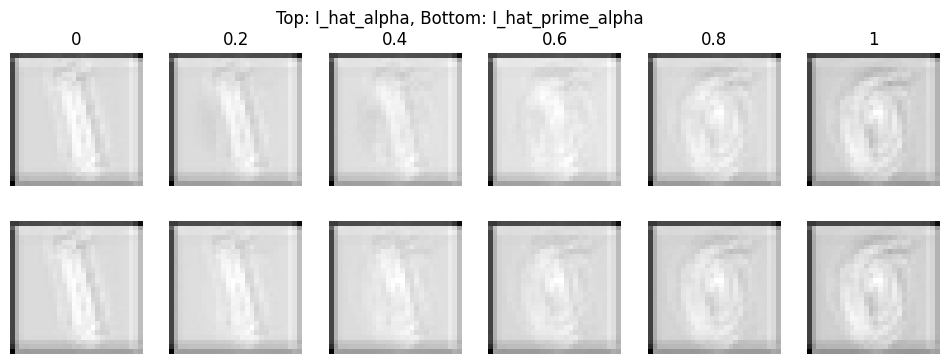

========== BEGINNING OF Sparse Autoencoder Autoencoder RUN 8==========


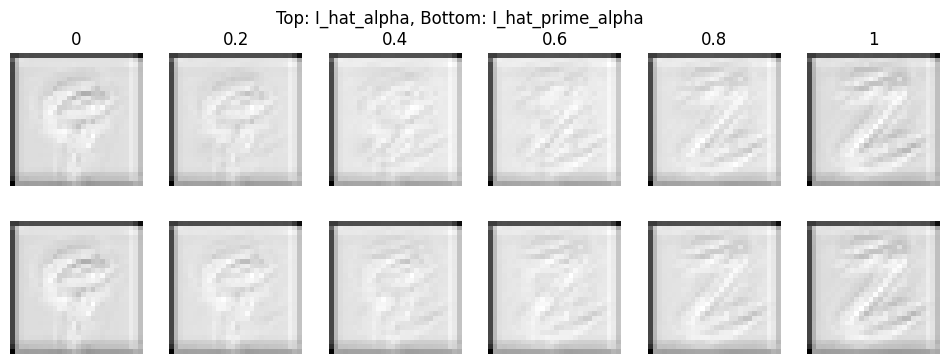

========== BEGINNING OF Sparse Autoencoder Autoencoder RUN 9==========


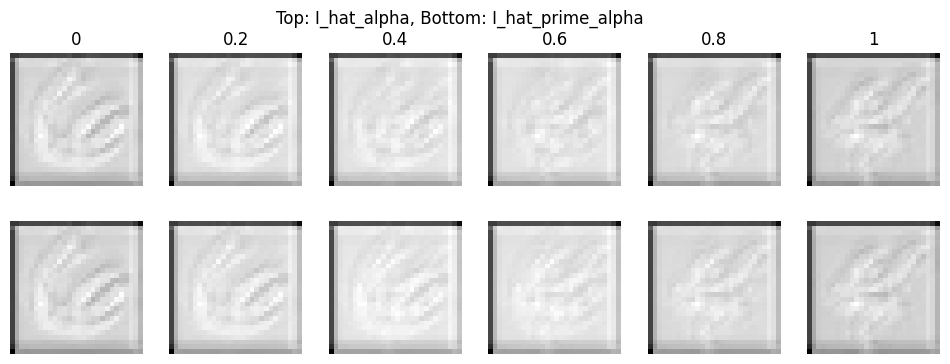

========== BEGINNING OF Sparse Autoencoder Autoencoder RUN 10==========


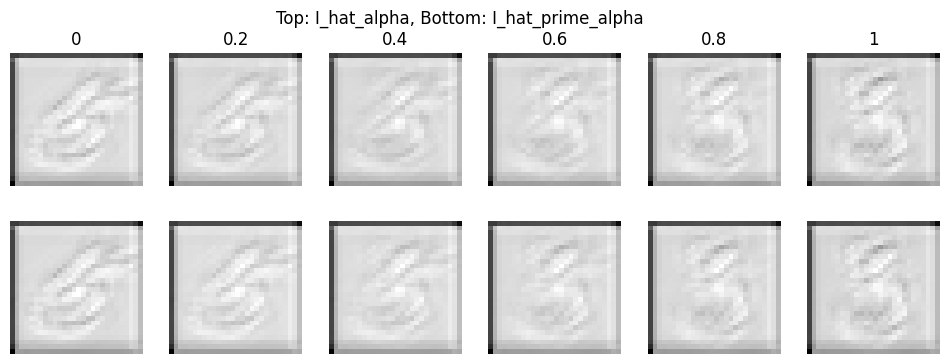

========== BEGINNING OF Sparse Autoencoder Autoencoder RUN 11==========


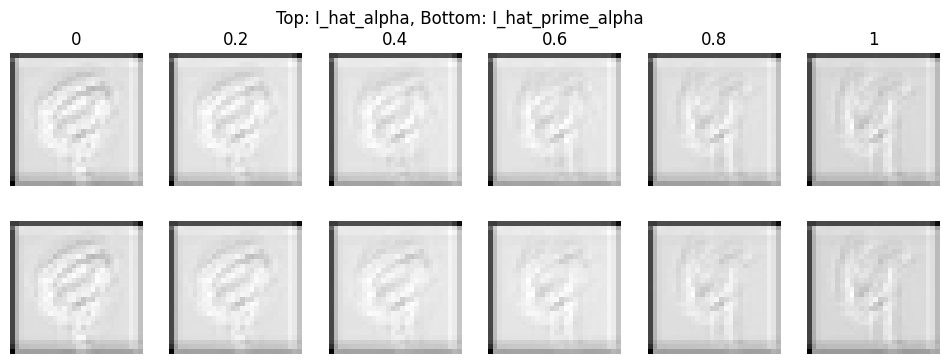

========== BEGINNING OF Sparse Autoencoder Autoencoder RUN 12==========


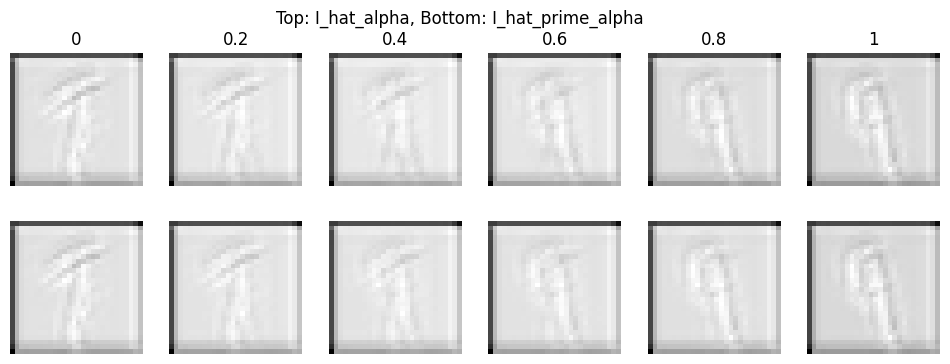

========== BEGINNING OF Sparse Autoencoder Autoencoder RUN 13==========


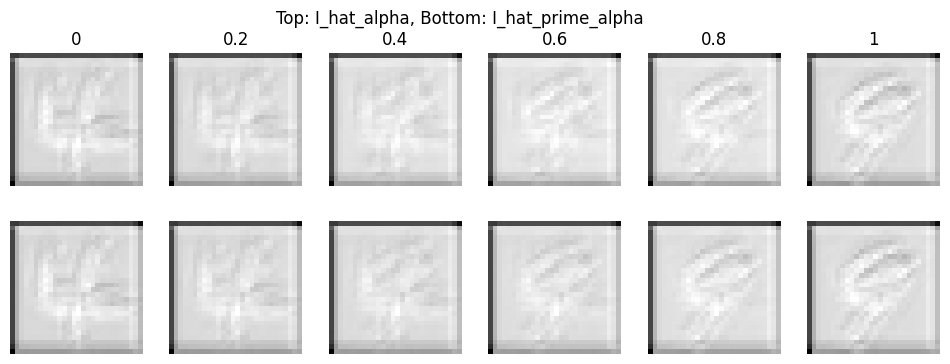

========== BEGINNING OF Sparse Autoencoder Autoencoder RUN 14==========


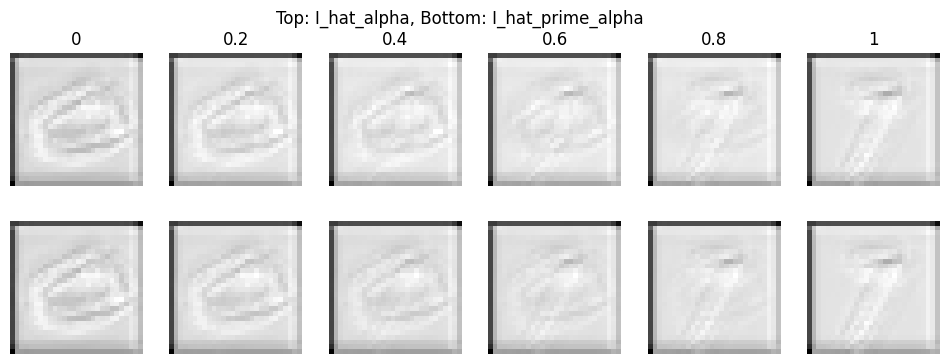

========== BEGINNING OF Sparse Autoencoder Autoencoder RUN 15==========


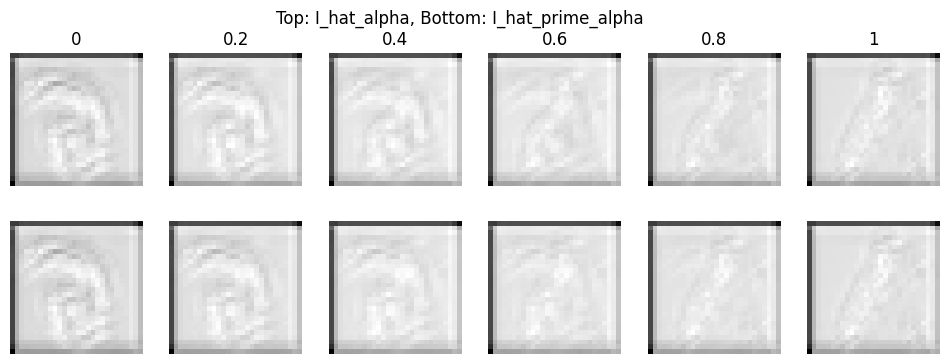

========== BEGINNING OF Sparse Autoencoder Autoencoder RUN 16==========


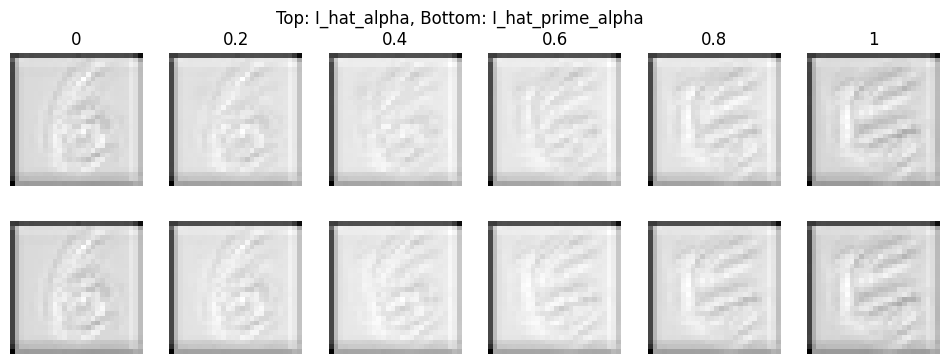

========== BEGINNING OF Sparse Autoencoder Autoencoder RUN 17==========


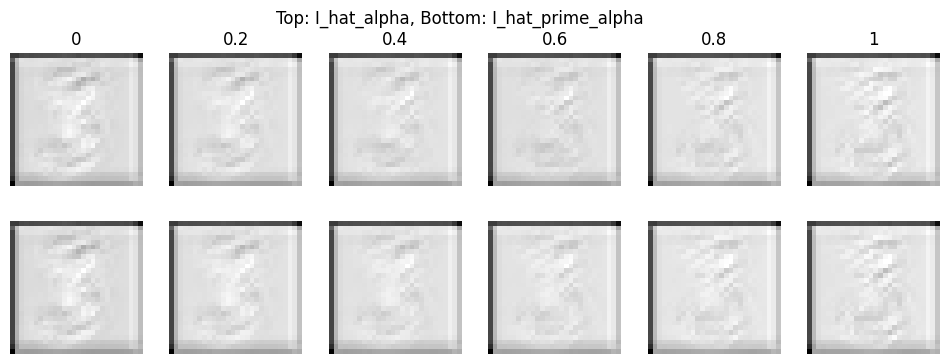

========== BEGINNING OF Sparse Autoencoder Autoencoder RUN 18==========


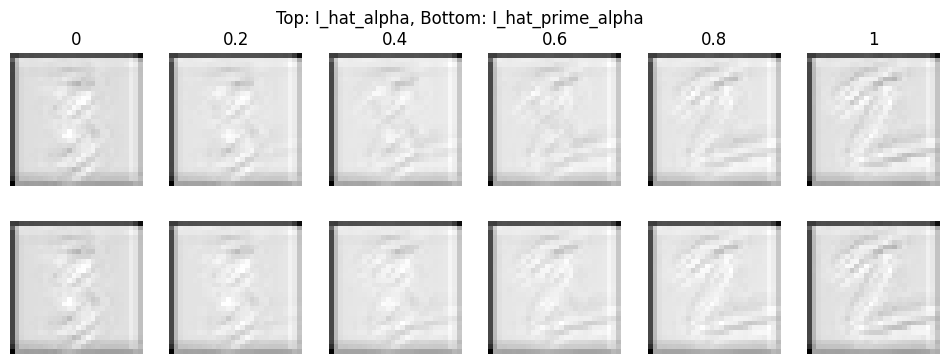

========== BEGINNING OF Sparse Autoencoder Autoencoder RUN 19==========


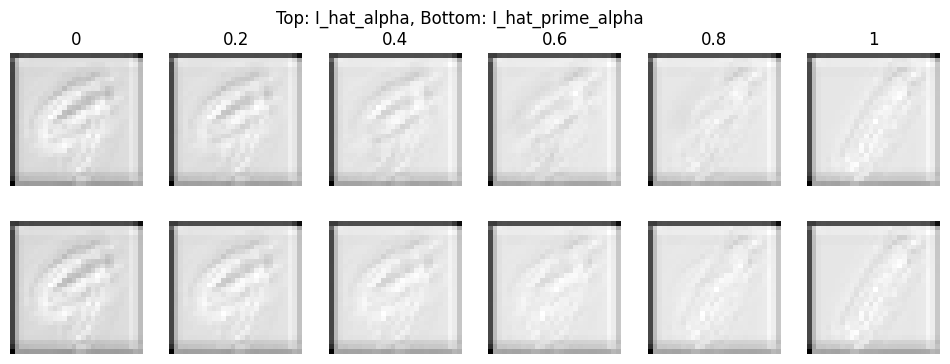

========== BEGINNING OF Sparse Autoencoder Autoencoder RUN 20==========


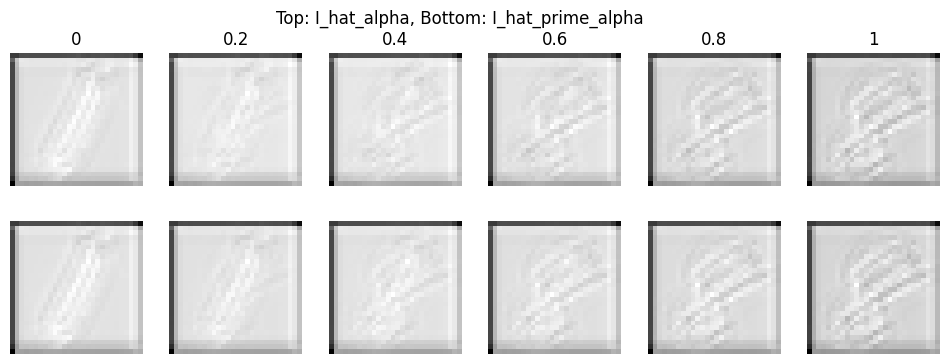

Mean PSNR: inf, Mean L2: 0.5110

========== BEGINNING OF Contractive Autoencoder Autoencoder RUN 1==========


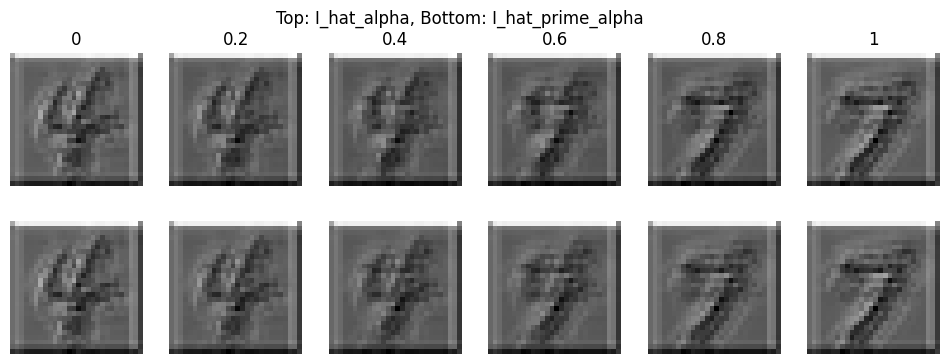

========== BEGINNING OF Contractive Autoencoder Autoencoder RUN 2==========


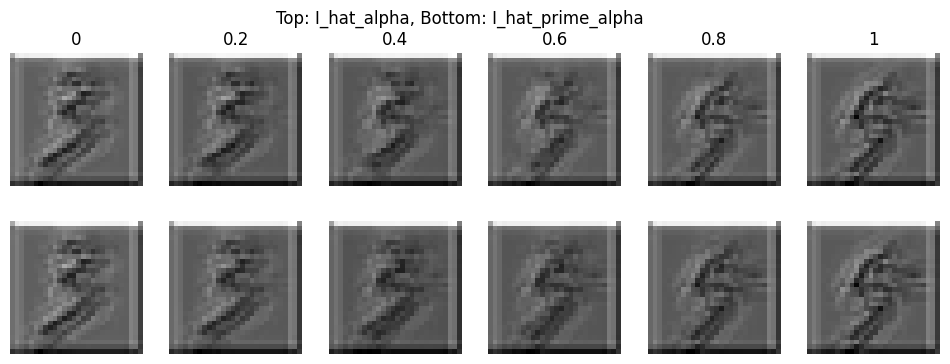

========== BEGINNING OF Contractive Autoencoder Autoencoder RUN 3==========


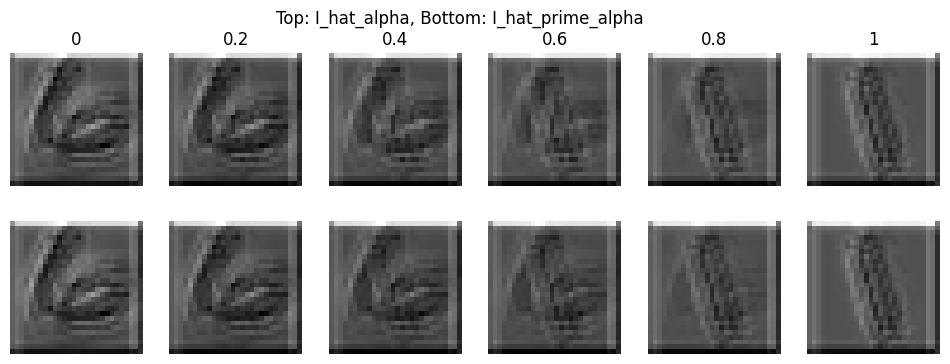

========== BEGINNING OF Contractive Autoencoder Autoencoder RUN 4==========


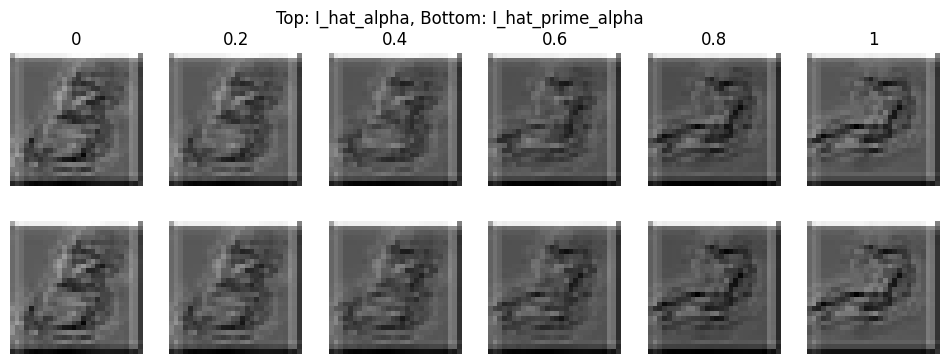

========== BEGINNING OF Contractive Autoencoder Autoencoder RUN 5==========


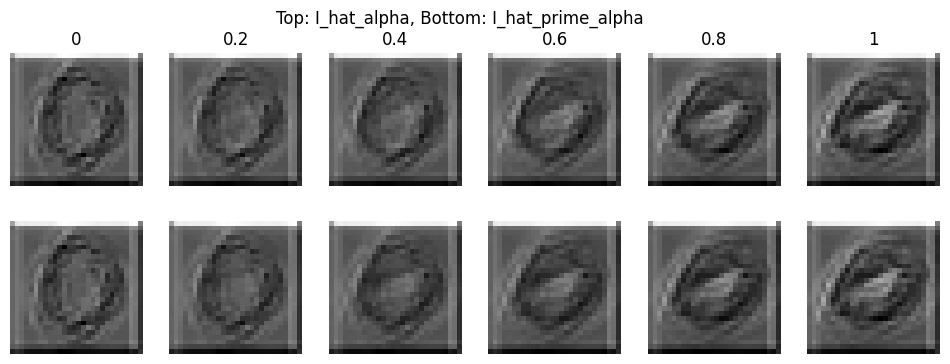

========== BEGINNING OF Contractive Autoencoder Autoencoder RUN 6==========


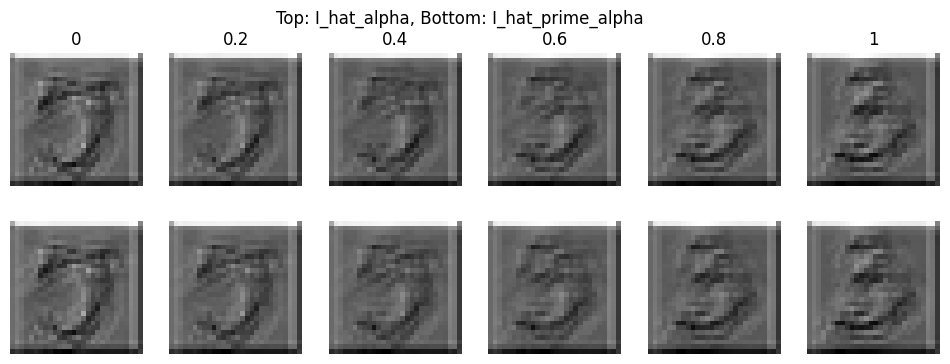

========== BEGINNING OF Contractive Autoencoder Autoencoder RUN 7==========


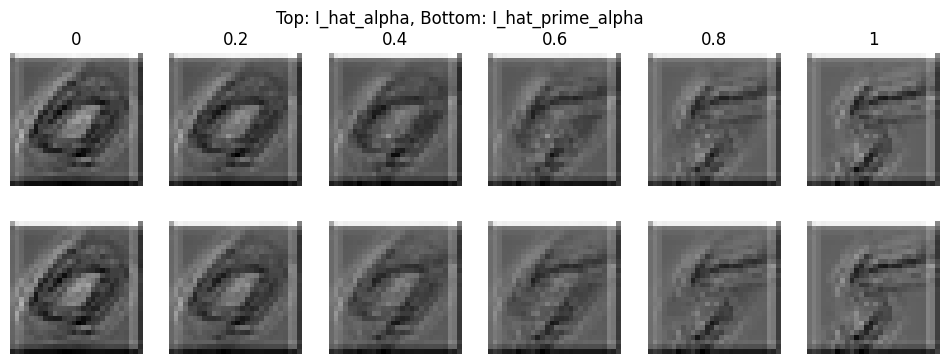

========== BEGINNING OF Contractive Autoencoder Autoencoder RUN 8==========


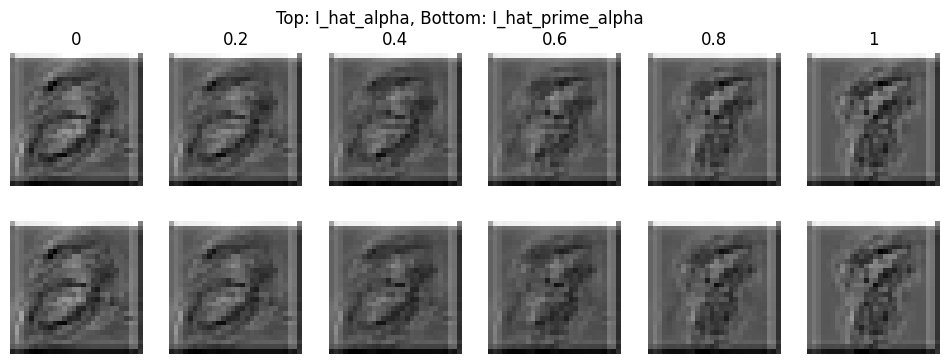

========== BEGINNING OF Contractive Autoencoder Autoencoder RUN 9==========


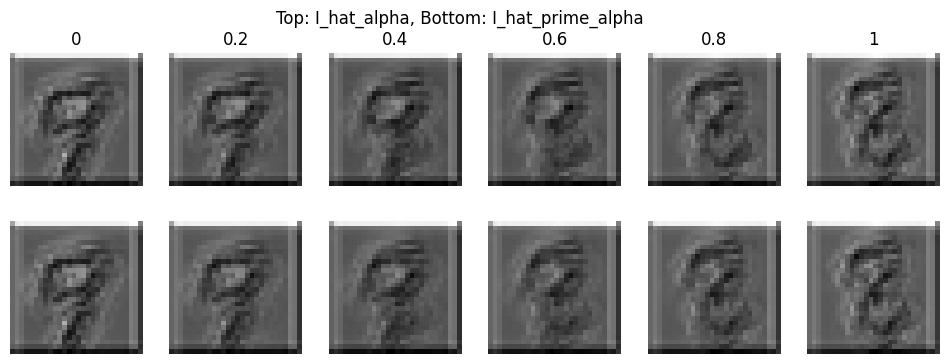

========== BEGINNING OF Contractive Autoencoder Autoencoder RUN 10==========


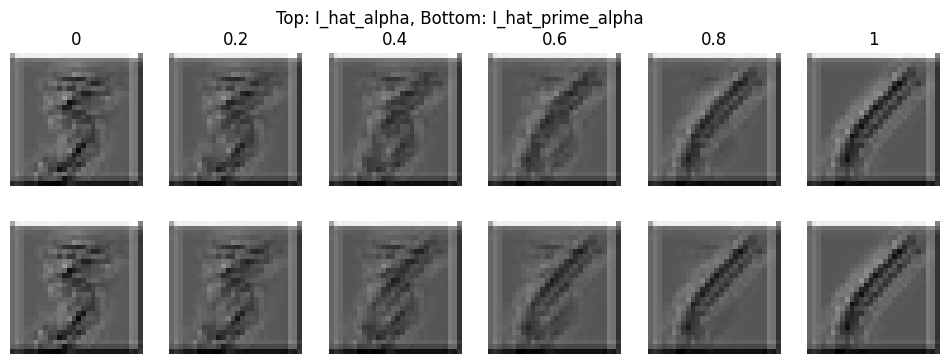

========== BEGINNING OF Contractive Autoencoder Autoencoder RUN 11==========


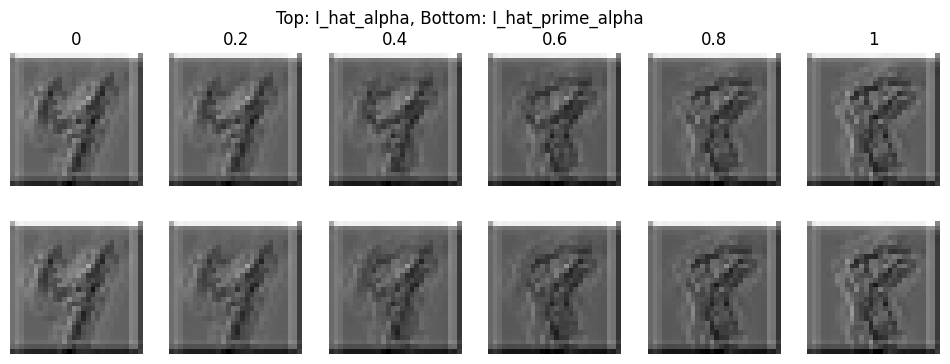

========== BEGINNING OF Contractive Autoencoder Autoencoder RUN 12==========


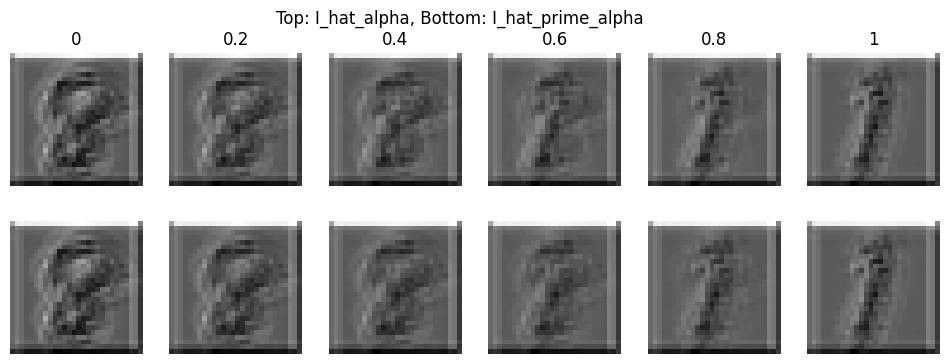

========== BEGINNING OF Contractive Autoencoder Autoencoder RUN 13==========


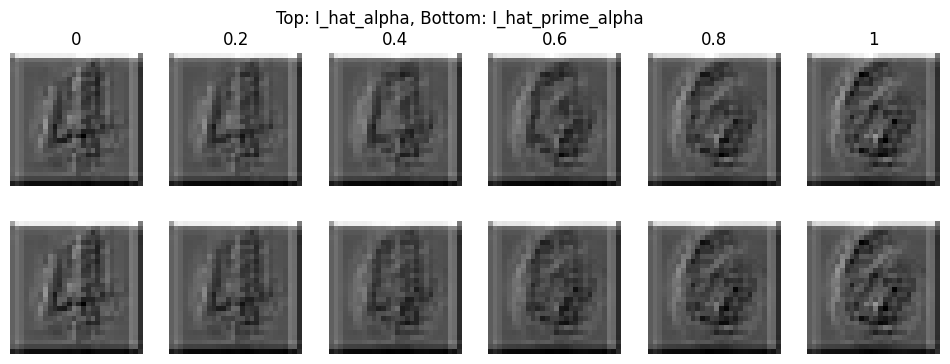

========== BEGINNING OF Contractive Autoencoder Autoencoder RUN 14==========


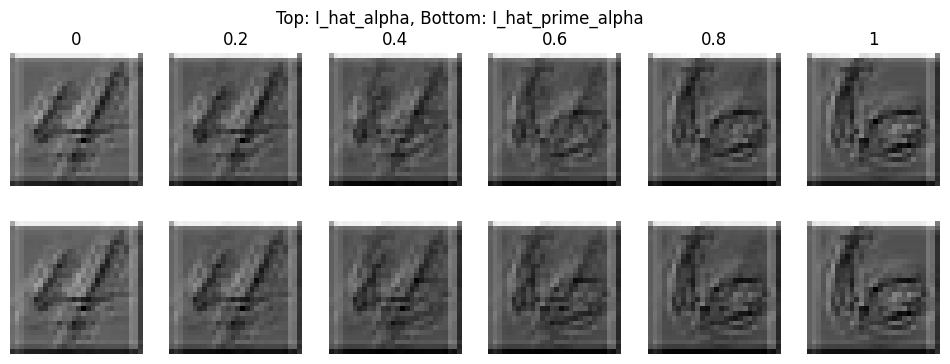

========== BEGINNING OF Contractive Autoencoder Autoencoder RUN 15==========


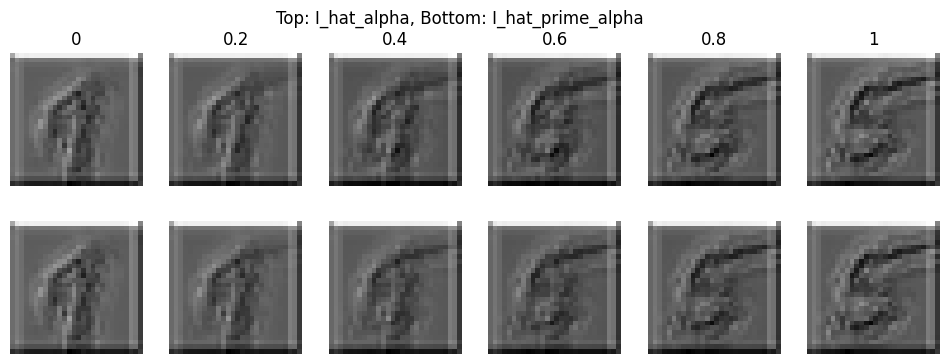

========== BEGINNING OF Contractive Autoencoder Autoencoder RUN 16==========


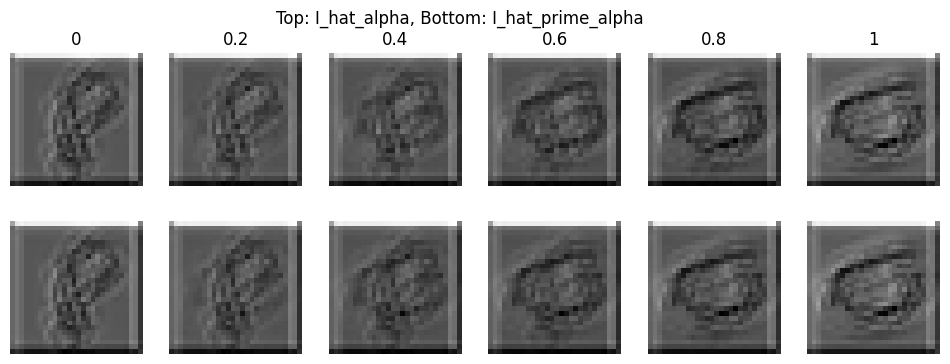

========== BEGINNING OF Contractive Autoencoder Autoencoder RUN 17==========


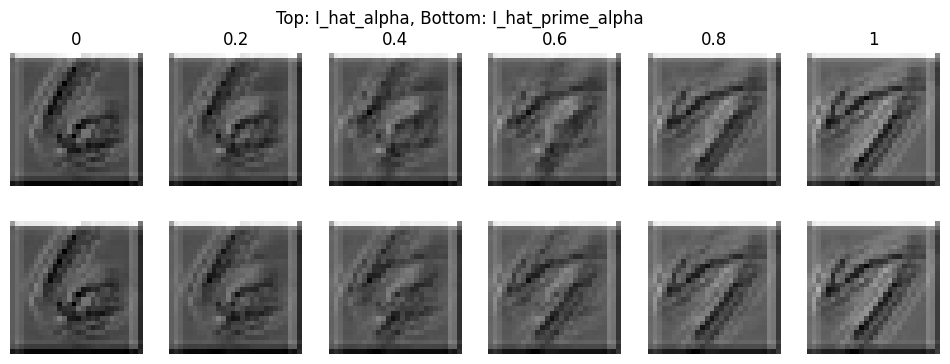

========== BEGINNING OF Contractive Autoencoder Autoencoder RUN 18==========


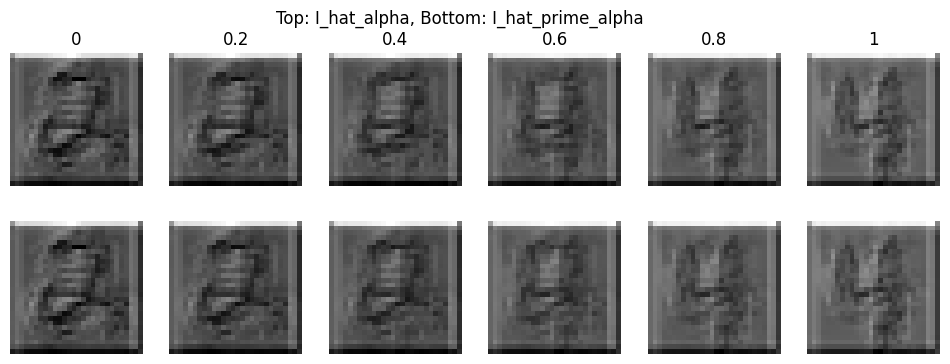

========== BEGINNING OF Contractive Autoencoder Autoencoder RUN 19==========


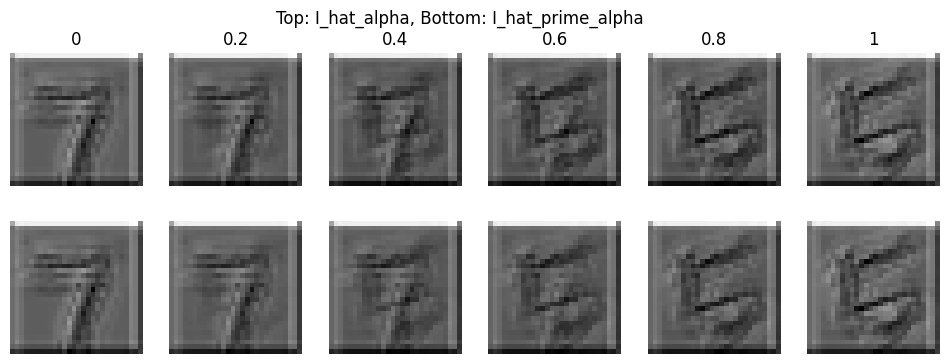

========== BEGINNING OF Contractive Autoencoder Autoencoder RUN 20==========


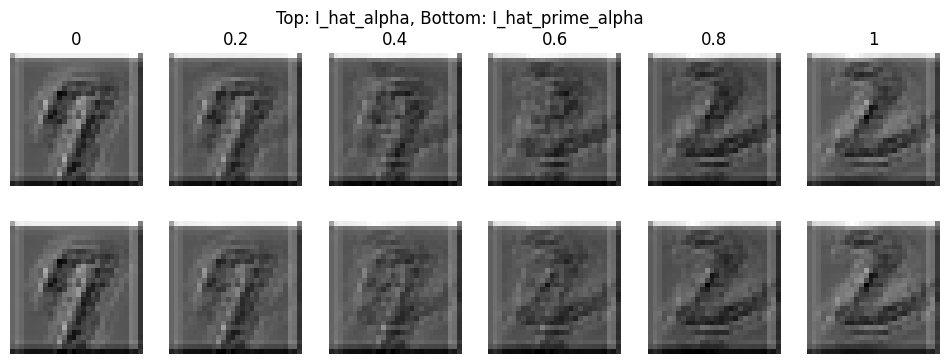

Mean PSNR: inf, Mean L2: 0.5010



In [ ]:
extract_and_compare(trained_sparse_autoencoder_model, 'Sparse Autoencoder')
extract_and_compare(trained_contractive_autoencoder_model, 'Contractive Autoencoder')

## __(c) After training the autoencoders, you want to check if the embeddings of different digits are different and embeddings within a class are similar. For this purpose, you propose to perform the classification of the digits based on the embeddings obtained by the encoders and check the accuracy of classifications for each of the Auto-encoder. Report the classification accuracy for each of the AE and report which one is better. Use any inbuilt classifier to solve the classification problem.__

In [ ]:
def classify_embeddings(model, encoder_type):
    device = next(model.parameters()).device
    ss = StandardScaler()
    model.eval()
    X_train, y_train, X_test, y_test = [], [], [], []
    with torch.no_grad():
      for i, (batch_features, batch_labels) in enumerate(train_dataloader):
        if i == 100: # here we restricted only to 100 as for the total of 1000 items of 60 per batch, session crashed repeatedly
          break
        batch_features = batch_features.to(device)
        h = model.encoder(batch_features)
        h_flat = h.view(h.size(0), -1)
        X_train.append(h_flat.cpu().numpy())
        y_train.append(batch_labels.numpy())
      for i, (batch_features, batch_labels) in enumerate(test_dataloader):
        if i == 100:
          break
        batch_features = batch_features.to(device)
        h = model.encoder(batch_features)
        h_flat = h.view(h.size(0), -1)
        X_test.append(h_flat.cpu().numpy())
        y_test.append(batch_labels.numpy())
    X_train = ss.fit_transform(np.concatenate(X_train))
    y_train = np.concatenate(y_train)
    X_test = ss.transform(np.concatenate(X_test))
    y_test = np.concatenate(y_test)
    lr = LogisticRegression(max_iter=1000, )
    lr.fit(X_train, y_train)
    preds = lr.predict(X_test)
    acc = accuracy_score(y_test, preds)
    print(f"Classification accuracy for {encoder_type} Autoencoder: {acc*100:.2f}%\n")
    conf_matrix = confusion_matrix(y_test, preds)

    sns.heatmap(conf_matrix, annot=True, fmt='', cbar=False, cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix {encoder_type}')
    print("="*75)


Classification accuracy for Sparse Autoencoder Autoencoder: 96.40%



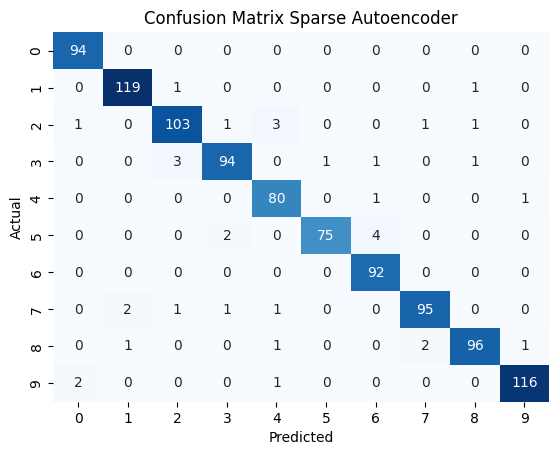

In [ ]:
device = get_device_config()

classify_embeddings(trained_sparse_autoencoder_model.to(device), 'Sparse Autoencoder')

Classification accuracy for Contractive Autoencoder Autoencoder: 93.70%



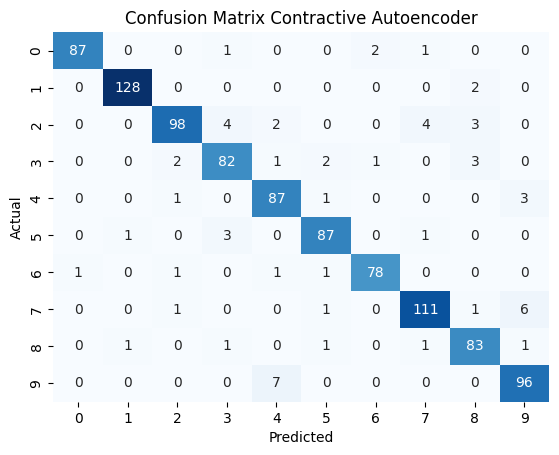

In [ ]:
classify_embeddings(trained_contractive_autoencoder_model.to(device), 'Contractive Autoencoder')

# __2. Implement variational Auto-encoders. Use the Frey Face dataset to train your network. Sample points from the learned distribution by varying different latent variables to show that your network has learned meaningful latent variables. Set the embedding vector size to 20.__

## __Data Loading and visualization__

In [ ]:

print(f"Enter whether you want to upload the dataset or read directly:\n1. Upload Dataset\n2. Read directly\n")
while True:
  x = input()
  if x == '1':
    try:
      from google.colab import files
      uploaded = files.upload()
    except ImportError:
      print(f"Colab Import Error")
    break
  elif x == '2':
    data = scipy.io.loadmat('frey_rawface.mat')
    print(data.keys())
    break
  else:
    print("Invalid Input")





Enter whether you want to upload the dataset or read directly:
1. Upload Dataset
2. Read directly

1


Saving frey_rawface.mat to frey_rawface.mat


In [ ]:
import scipy.io
import numpy as np

# Loading the mat file as we found from kaggle
data = scipy.io.loadmat('frey_rawface.mat')
print(data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'ff'])


In [ ]:
frey_faces = data['ff']
frey_faces = frey_faces.T
print(frey_faces.shape) # It shows us that there are 1965 samples each of 28 * 20(560) shaped image

(1965, 560)


In [ ]:
train_set = frey_faces[: int(0.8 * len(frey_faces))]
test_set = frey_faces[int(0.8 * len(frey_faces)):]
frey_faces = shuffle(frey_faces, random_state=101)
os.makedirs('./data/Q2_train', exist_ok=True)
os.makedirs('./data/Q2_test', exist_ok=True)


for i, img in enumerate(train_set):
  img_tensor = torch.tensor(img, dtype=torch.float32).reshape(1, 28, 20)
  save_image(img_tensor, f'./data/Q2_train/image{i+1}.png')

for i, img in enumerate(test_set):
  img_tensor = torch.tensor(img, dtype=torch.float32).reshape(1, 28, 20)
  save_image(img_tensor, f'./data/Q2_test/image{i+1}.png')

## __Implementing Variational Autoencoder__

In [ ]:
class CustomDataset(nn.Module):
  def __init__(self,data):
    self.data = torch.tensor(data, dtype=torch.float32) / 255.0

  def __len__(self):
    return len(self.data)

  def __getitem__(self, i):
    img = self.data[i].reshape(1,28,20)
    return img, img



train_var_autoencoder_dataloader = DataLoader(CustomDataset(train_set), batch_size=64, shuffle=True)
test_var_autoencoder_dataloader = DataLoader(CustomDataset(test_set), batch_size=64, shuffle=True)

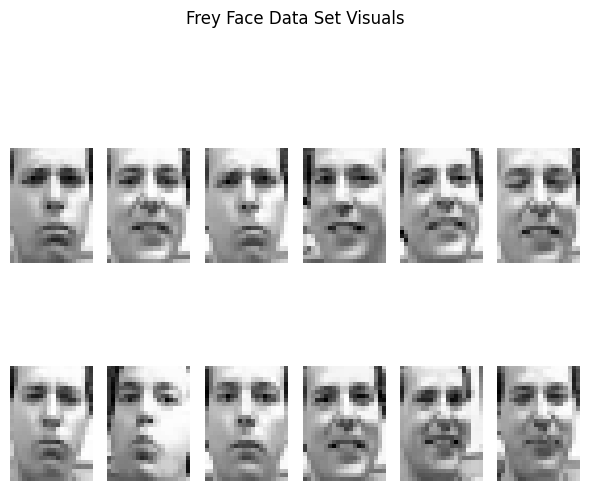

In [ ]:
fig, axes = plt.subplots(2, 6, figsize=(6, 6))
axes = axes.flatten()
fig.suptitle("Frey Face Data Set Visuals")
for i in range(12):
  axes[i].imshow(frey_faces[i].reshape(28,20), cmap='gray')
  axes[i].set_axis_off()

plt.tight_layout()
plt.show()

In [ ]:
class VariationalAutoencoder(nn.Module):
  def __init__(self,input_dim, hidden_dim1=400, hidden_dim2=200, latent_dim=20):
    super().__init__()

    #for the encoder part
    self.img_to_hidden1 = nn.Linear(input_dim, hidden_dim1)
    self.hidden1_to_hidden2 = nn.Linear(hidden_dim1, hidden_dim2)
    self.hidden2_to_mu = nn.Linear(hidden_dim2, latent_dim)
    self.hidden2_to_sigma = nn.Linear(hidden_dim2, latent_dim)


    #for the encoder part
    self.latent_to_hidden2 = nn.Linear(latent_dim, hidden_dim2)
    self.hidden2_to_hidden1 = nn.Linear(hidden_dim2, hidden_dim1)
    self.hidden1_to_img = nn.Linear(hidden_dim1, input_dim)

  def encode(self,x):
    h1 = nn.ReLU()(self.img_to_hidden1(x))
    h2 = nn.ReLU()(self.hidden1_to_hidden2(h1))
    mu = self.hidden2_to_mu(h2)
    sigma = self.hidden2_to_sigma(h2)
    return mu, sigma

  def decode(self,z):
    h2 = nn.ReLU()(self.latent_to_hidden2(z))
    h1 = nn.ReLU()(self.hidden2_to_hidden1(h2))
    img = nn.Sigmoid()(self.hidden1_to_img(h1))
    return img


  def forward(self,x):
    mu, sigma = self.encode(x)
    epsilon = torch.randn_like(sigma)
    z = mu + sigma * epsilon
    recon = self.decode(z)
    return recon, mu, sigma


  def ELBO_loss(self, recon, x, mu, sigma):
    bce_loss = nn.BCELoss(reduction="sum")(recon, x)
    kl_divergence_loss = -0.5 * torch.sum(1 + sigma - mu.pow(2) - sigma.exp())
    total_loss = bce_loss + kl_divergence_loss
    return total_loss, bce_loss, kl_divergence_loss

In [ ]:
def train_vae(num_epochs):
  device = get_device_config()

  model = VariationalAutoencoder(560).to(device)
  optimizer = optim.Adam(model.parameters(), lr=0.001)
  epoch_loss_list = []
  for e in range(num_epochs):
    epoch_loss = 0
    for batch_features, batch_labels in train_var_autoencoder_dataloader:
      batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
      recon, mu, sigma = model(batch_features.reshape(batch_features.shape[0], -1))
      loss, bce_loss, kl_loss = model.ELBO_loss(recon, batch_features.reshape(batch_features.shape[0], -1), mu, sigma)
      epoch_loss = epoch_loss + loss.item()
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    epoch_loss_list.append(epoch_loss / len(train_var_autoencoder_dataloader))
    print(f"Epoch {e + 1} Avg Bce Loss: {bce_loss.item() / len(train_var_autoencoder_dataloader):.2f}, Avg. KL Div. Loss: {kl_loss.item()  / len(train_var_autoencoder_dataloader):.2f}, Avg. Loss:{loss.item()  / len(train_var_autoencoder_dataloader):.2f}")
    print("="*75)
  return model, epoch_loss

In [ ]:
trained_auto_vae_model, train_loss_vae = train_vae(50)

Epoch 1 Avg Bce Loss: 504.96, Avg. KL Div. Loss: 0.22, Avg. Loss:505.17
Epoch 2 Avg Bce Loss: 505.77, Avg. KL Div. Loss: 0.05, Avg. Loss:505.82
Epoch 3 Avg Bce Loss: 501.41, Avg. KL Div. Loss: 0.04, Avg. Loss:501.45
Epoch 4 Avg Bce Loss: 504.86, Avg. KL Div. Loss: 0.07, Avg. Loss:504.93
Epoch 5 Avg Bce Loss: 505.26, Avg. KL Div. Loss: 0.05, Avg. Loss:505.31
Epoch 6 Avg Bce Loss: 499.86, Avg. KL Div. Loss: 0.03, Avg. Loss:499.90
Epoch 7 Avg Bce Loss: 506.09, Avg. KL Div. Loss: 0.11, Avg. Loss:506.20
Epoch 8 Avg Bce Loss: 498.16, Avg. KL Div. Loss: 0.07, Avg. Loss:498.23
Epoch 9 Avg Bce Loss: 500.06, Avg. KL Div. Loss: 0.10, Avg. Loss:500.16
Epoch 10 Avg Bce Loss: 498.02, Avg. KL Div. Loss: 0.10, Avg. Loss:498.13
Epoch 11 Avg Bce Loss: 496.99, Avg. KL Div. Loss: 0.10, Avg. Loss:497.09
Epoch 12 Avg Bce Loss: 497.62, Avg. KL Div. Loss: 0.12, Avg. Loss:497.74
Epoch 13 Avg Bce Loss: 496.53, Avg. KL Div. Loss: 0.09, Avg. Loss:496.62
Epoch 14 Avg Bce Loss: 498.76, Avg. KL Div. Loss: 0.17, Avg.

## __Inference__

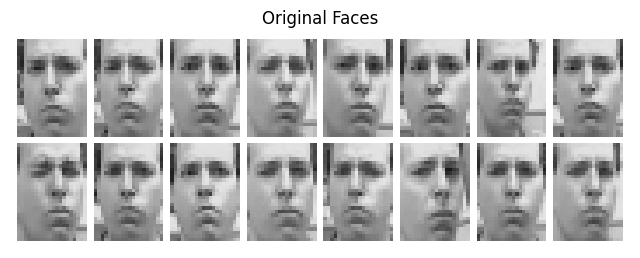

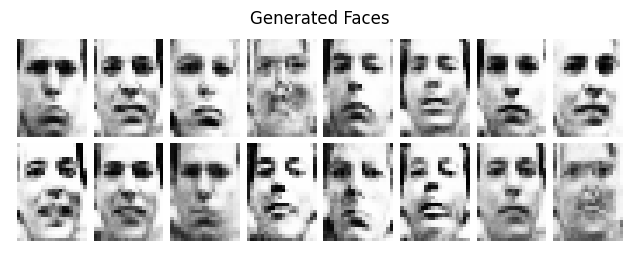

In [ ]:
def show_grid(tensor_images, nrow=8, title=None):
    grid = make_grid(tensor_images, nrow=nrow, pad_value=1.0)
    plt.figure(figsize=(8, 4))
    plt.imshow(grid.permute(1, 2, 0).cpu().squeeze(), cmap="gray")
    plt.axis("off")
    if title: plt.title(title)
    plt.show()



device = get_device_config()
trained_auto_vae_model.eval()
with torch.no_grad():
    #Original images
    batch_features, _ = next(iter(test_var_autoencoder_dataloader))
    orig = batch_features.to(device)
    show_grid(orig[:16].view(-1, 1, 28, 20), nrow=8, title="Original Faces")



    #Randomly generated 16 latent vectors each of dimension 20
    z = torch.randn(16, 20).to(device)
    gen = trained_auto_vae_model.decode(z)
    show_grid(gen.view(-1, 1, 28, 20), nrow=8, title="Generated Faces")
